In [1]:
# Imports

import math, pickle, os, copy, sys, scipy.io, json, datetime, pickle

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

from numpy import random
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

# Add the project directory to the path
PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(1, PROJECT_DIR)

from utils_pv import *
from samples.data_sim import PVDataset

#### FL
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from trainer import Trainer
from models import *
from metrics import mse

# Set the random seed
random_seed = 46
random.seed(random_seed)
np.random.seed(random_seed)
random_state = np.random.RandomState(random_seed)

# Set the device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = 'mps'

### Data generation

In [2]:
# Generate data for 1 client

months_name = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}

train_columns = ['H_sun', 'T2m', 'WS10m', 'hourofd_x', 'hourofd_y', 'dayofy_x', 'dayofy_y', 'station_irrad_direct_prev', 'station_irrad_diffuse_prev', 'lag 1']

hour_begin, hour_end = 8, 18

NUM_CLIENTS=1

city_names = ['Lausanne']
env_dict = {'city_names':city_names,
            'num_clients': NUM_CLIENTS, 'num_modes': len(city_names),
            'tilt_std': 5, 'az_std': 0, 'weather_dev':0.1,
            'irrad_std':0.2, 'altitude_dev':0.1, 'shadow_peak_red':1,
            'module_name': get_available_modules('sandia')[0:NUM_CLIENTS], #['Canadian_Solar_CS5P_220M___2009_'],
            'inverter_name': get_available_inverters('cec')[0:NUM_CLIENTS], # ['ABB__MICRO_0_25_I_OUTD_US_208__208V_'],
            'lags':[1], 'months':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'hours':np.arange(hour_begin, hour_end), 
            'train_scenarios':{'1y':{'m_train':None, 'train_years':[2018], 'valid_years':2019}}}

env_dict = PVDataset(env_dict).generate_clients_data()

time_series = env_dict['train_scenarios']['1y']['time_series'][0]

# Remove nights
time_series = time_series[time_series['hour_day'].isin(np.arange(hour_begin, hour_end))]

# Add column day_of_month using column time
time_series['day'] = time_series['time'].dt.day

# Reorder columns
time_series = time_series[['time', 'year', 'month', 'day', 'hour_day', 'H_sun', 'T2m', 'WS10m', 'hourofd_x', 'hourofd_y', 'dayofy_x', 'dayofy_y', 'station_irrad_direct_prev', 'station_irrad_diffuse_prev', 'lag 1', 'target']]
time_series.sample(3)

,time,year,month,day,hour_day,H_sun,T2m,WS10m,hourofd_x,hourofd_y,dayofy_x,dayofy_y,station_irrad_direct_prev,station_irrad_diffuse_prev,lag 1,target
80342,2014-03-02 15:10:00,2014,3,2,15,19.74,15.806133,1.322021,-7.071068e-01,-0.707107,0.867456,0.497513,0.000000,83.888610,11.813488,24.716404
47821,2010-06-16 14:10:00,2010,6,16,14,51.01,12.308159,0.666466,-5.000000e-01,-0.866025,0.263665,-0.964614,0.000000,78.590382,10.458863,13.134210
62459,2012-02-16 12:10:00,2012,2,16,12,30.92,5.132578,2.181787,1.224647e-16,-1.000000,0.723644,0.690173,2.890523,171.632869,26.479149,17.932810


### 1. One model for 3 months

> Train a model using 3 consecutive months of data, predict the same three months of the next year.

In [55]:
# Filter the data for three selected months (continuous)
selected_months = [7, 8, 9]
train_year = [2018]
test_year = 2019

x_train = time_series[(time_series.year.isin(train_year)) & (time_series.month.isin(selected_months))][train_columns].values
y_train = time_series[(time_series.year.isin(train_year)) & (time_series.month.isin(selected_months))]['target'].values

x_test = time_series[(time_series.year==test_year) & (time_series.month.isin(selected_months))][train_columns].values
y_test = time_series[(time_series.year==test_year) & (time_series.month.isin(selected_months))]['target'].values

# Normalize the data
x_mean = np.mean(x_train, axis=0)
x_std = np.std(x_train, axis=0)
y_mean = np.mean(y_train)
y_std = np.std(y_train)

x_train = (x_train - x_mean) / x_std
x_test = (x_test - x_mean) / x_std
y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

# Reshape the data
y_train = y_train.reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((920, 10), (920, 1), (920, 10), (920, 1))

In [56]:
NUM_EPOCHS = 300

LR_GRID = [1e-3, 1e-2, 1e-1]
WEIGHT_DECAY_GRID = [5e-4, 5e-3, 5e-2]

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("DEVICE:", DEVICE)

DEVICE: cpu


In [62]:
# Run experiments

all_results_dict = dict()

for lr_ in LR_GRID:
    all_results_dict[lr_] = dict()
    for weight_decay_ in WEIGHT_DECAY_GRID:
        all_results_dict[lr_][weight_decay_] = dict()
        
        print(f"LR: {lr_} | Weight Decay: {weight_decay_}")
        
        ###### Define the model, optimizer, loss function and history
        training_loss_history = []
        
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
        torch.manual_seed(random_seed)

        # Create the model, optimizer, and trainer
        # model = SimpleNN(input_dim=len(train_columns), output_dim=1, hidden_dim=5).to(DEVICE)
        model = TwoLayerNN(input_dim=len(train_columns), output_dim=1, hidden_dim1=32, hidden_dim2=32).to(DEVICE)

        optimizer = optim.SGD(
            [param for param in model.parameters() if param.requires_grad],
            lr=lr_,
            momentum=0.9,
            weight_decay=weight_decay_,
        )

        trainer = Trainer(
            model=model,
            criterion=nn.MSELoss(reduction='none').to(DEVICE),
            metric=mse,
            device=DEVICE,
            optimizer=optimizer,
            cast_label=False,
        )
        
        ###### Define training data
        
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train), torch.tensor(y_train))
        train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=False)
        train_iterator = iter(train_dataloader)
        
        ###### Training loop
        for epoch in tqdm(range(NUM_EPOCHS)):
        
            # Clear gradients from the previous iteration
            trainer.optimizer.zero_grad()

            ## Training Loss
            try:
                x_batch, y_batch = next(train_iterator)
            except StopIteration:
                train_iterator = iter(train_dataloader)
                x_batch, y_batch = next(train_iterator)
        
            x_batch = x_batch.to(DEVICE).type(torch.float32)
            y_batch = y_batch.to(DEVICE).type(torch.float32)

            # Forward pass
            outs_batch = trainer.model(x_batch)
            loss_batch = trainer.criterion(outs_batch, y_batch).mean()
            
            training_loss_history.append(loss_batch.detach().cpu().numpy())
        
            # Get gradients w.r.t to parameters
            loss_batch.backward()
            
            # Update the parameters
            trainer.optimizer.step()
            # print(f"Epoch: {epoch} | Training Loss: {loss_batch:0.3f}")
            
        ###### Test the model
        y_pred = trainer.model(torch.tensor(x_test).to(DEVICE).type(torch.float32))
        loss_test = trainer.criterion(y_pred, torch.tensor(y_test).to(DEVICE).type(torch.float32)).mean()
        
        print(f"Validation Loss: {loss_test:0.3f}")
        
        # Save the results in a json file
        all_results_dict[lr_][weight_decay_] = {'training_loss': training_loss_history,
                                    'test_loss': loss_test.detach().cpu().numpy(),
                                    'y_pred': y_pred.detach().cpu().numpy() * y_std + y_mean,
                                    'y_test': y_test * y_std + y_mean}

LR: 0.001 | Weight Decay: 0.0005


100%|██████████| 300/300 [00:00<00:00, 446.29it/s]


Validation Loss: 0.177
LR: 0.001 | Weight Decay: 0.005


100%|██████████| 300/300 [00:00<00:00, 565.32it/s]


Validation Loss: 0.177
LR: 0.001 | Weight Decay: 0.05


100%|██████████| 300/300 [00:00<00:00, 637.27it/s]


Validation Loss: 0.177
LR: 0.01 | Weight Decay: 0.0005


100%|██████████| 300/300 [00:00<00:00, 559.65it/s]


Validation Loss: 0.159
LR: 0.01 | Weight Decay: 0.005


100%|██████████| 300/300 [00:00<00:00, 546.00it/s]


Validation Loss: 0.159
LR: 0.01 | Weight Decay: 0.05


100%|██████████| 300/300 [00:00<00:00, 534.39it/s]


Validation Loss: 0.159
LR: 0.1 | Weight Decay: 0.0005


100%|██████████| 300/300 [00:00<00:00, 434.63it/s]


Validation Loss: 0.176
LR: 0.1 | Weight Decay: 0.005


100%|██████████| 300/300 [00:00<00:00, 458.77it/s]


Validation Loss: 0.160
LR: 0.1 | Weight Decay: 0.05


100%|██████████| 300/300 [00:00<00:00, 498.76it/s]


Validation Loss: 0.161


In [63]:
# convert this a df with the columns lr, training_loss, validation_loss, outs_valid, y_valid
df = pd.DataFrame(columns=['lr', 'weight_decay', 'training_loss', 'test_loss', 'y_pred', 'y_test'])

for lr in all_results_dict.keys():
    for weight_decay in all_results_dict[lr].keys():
        df = df.append({'lr': lr,
                        'weight_decay': weight_decay,
                        'training_loss': all_results_dict[lr][weight_decay]['training_loss'],
                        'test_loss': all_results_dict[lr][weight_decay]['test_loss'],
                        'y_pred': all_results_dict[lr][weight_decay]['y_pred'],
                        'y_test': all_results_dict[lr][weight_decay]['y_test']}, ignore_index=True)

            
df

,lr,weight_decay,training_loss,test_loss,y_pred,y_test
0,0.001,0.0005,"[1.0387384, 1.0728896, 1.0331519, 1.063847, 1....",0.1767979,"[[52.046616], [67.88506], [86.232574], [87.734...","[[47.79270947711085], [77.00151460376317], [87..."
1,0.001,0.0050,"[1.0387384, 1.0728889, 1.0331498, 1.0638431, 1...",0.17668982,"[[51.95005], [67.78162], [86.1532], [87.71631]...","[[47.79270947711085], [77.00151460376317], [87..."
2,0.001,0.0500,"[1.0387384, 1.0728807, 1.0331306, 1.0638036, 1...",0.17678162,"[[51.247456], [66.8811], [85.30441], [87.442],...","[[47.79270947711085], [77.00151460376317], [87..."
3,0.010,0.0005,"[1.0387384, 1.0598029, 0.9844233, 0.9747007, 0...",0.15936694,"[[53.08222], [73.06441], [92.11696], [91.52962...","[[47.79270947711085], [77.00151460376317], [87..."
4,0.010,0.0050,"[1.0387384, 1.0597961, 0.9844188, 0.9747142, 0...",0.1585682,"[[52.648117], [73.12137], [91.774475], [91.482...","[[47.79270947711085], [77.00151460376317], [87..."
5,0.010,0.0500,"[1.0387384, 1.0597278, 0.984375, 0.9748477, 0....",0.15918964,"[[50.660282], [73.38634], [90.02927], [89.9761...","[[47.79270947711085], [77.00151460376317], [87..."
6,0.100,0.0005,"[1.0387384, 0.941421, 0.6195918, 0.39713007, 0...",0.17620046,"[[51.682983], [74.06497], [89.19382], [91.9052...","[[47.79270947711085], [77.00151460376317], [87..."
7,0.100,0.0050,"[1.0387384, 0.94146484, 0.62047386, 0.39929935...",0.16016354,"[[53.054016], [73.78349], [91.53387], [89.6546...","[[47.79270947711085], [77.00151460376317], [87..."
8,0.100,0.0500,"[1.0387384, 0.94190425, 0.6292605, 0.42124656,...",0.16065669,"[[49.70105], [75.41361], [90.44275], [90.78557...","[[47.79270947711085], [77.00151460376317], [87..."


In [64]:
best_params = df.groupby(['lr', 'weight_decay'])['test_loss'].mean().idxmin()
print(f'Best Learning Rate: {best_params[0]} | Best Weight Decay: {best_params[1]}')

Best Learning Rate: 0.01 | Best Weight Decay: 0.005


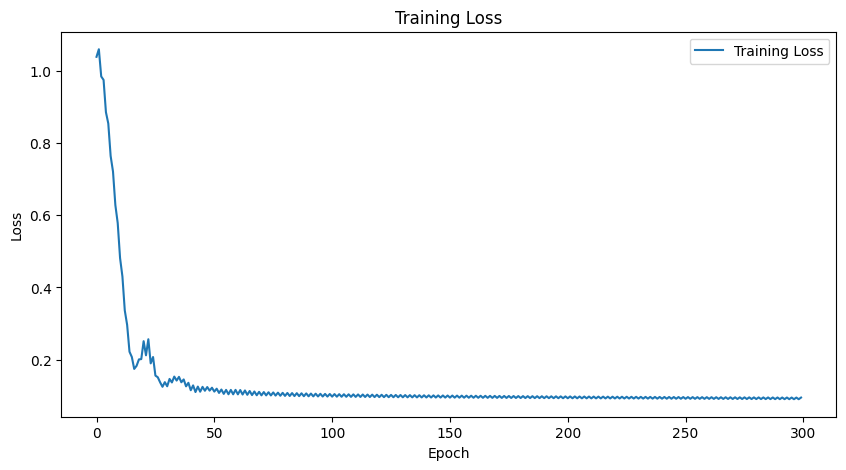

In [65]:
plt.figure(figsize=(10, 5))
plt.plot(df[df.lr==best_params[0]][df.weight_decay==best_params[1]]['training_loss'].values[0], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

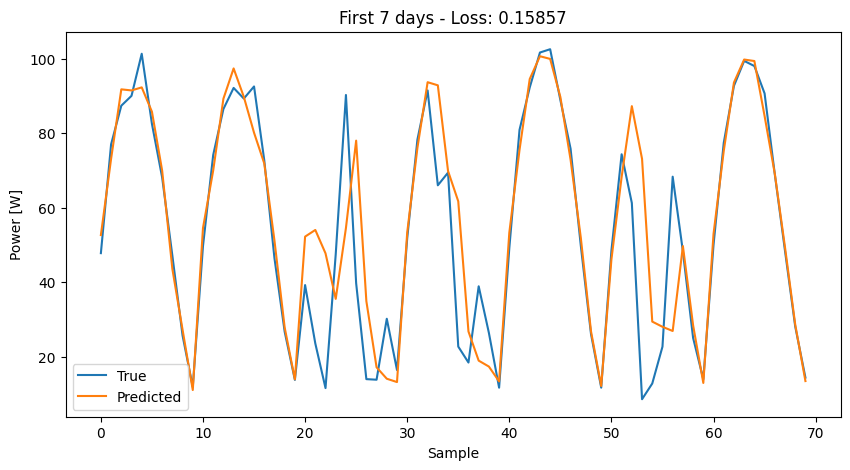

In [66]:
plt.figure(figsize=(10, 5))
plt.plot(df[df.lr==best_params[0]][df.weight_decay==best_params[1]]['y_test'].values[0][:7*10], label='True')
plt.plot(df[df.lr==best_params[0]][df.weight_decay==best_params[1]]['y_pred'].values[0][:7*10], label='Predicted')
plt.title(f'First 7 days - Loss: {df[df.lr==best_params[0]][df.weight_decay==best_params[1]]["test_loss"].values[0]:0.5f}')
plt.xlabel('Sample')
plt.ylabel('Power [W]')
plt.legend()
plt.show()

### 2. One model per month
> Train a model using one month of data, predict the same month of the next year.

In [42]:
selected_months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
train_year = [2018]
test_year = 2019

In [43]:
NUM_EPOCHS = 300

LR_GRID = [1e-3, 1e-2, 1e-1]
WEIGHT_DECAY_GRID = [5e-4, 5e-3, 5e-2]

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("DEVICE:", DEVICE)

DEVICE: cpu


In [44]:
# Run experiments
all_results_dict = dict()
for lr_ in LR_GRID:
    all_results_dict[lr_] = dict()
    for weight_decay_ in WEIGHT_DECAY_GRID:
        all_results_dict[lr_][weight_decay_] = dict()
        
        print(f"LR: {lr_} | Weight Decay: {weight_decay_}")
        
        y_pred_history = []
        
        # Loop over the months
        for index, row in enumerate(selected_months):
            all_results_dict[lr_][weight_decay_][months_name[row]] = dict()
        
            ###### Define month data
            
            x_train_month = time_series[(time_series.year.isin(train_year)) & (time_series.month == row)][train_columns].values
            y_train_month = time_series[(time_series.year.isin(train_year)) & (time_series.month == row)]['target'].values
            
            x_test_month = time_series[(time_series.year==test_year) & (time_series.month == row)][train_columns].values
            y_test_month = time_series[(time_series.year==test_year) & (time_series.month == row)]['target'].values
            
            # Normalize the data
            x_mean, x_std = np.mean(x_train_month, axis=0), np.std(x_train_month, axis=0)
            y_mean, y_std = np.mean(y_train_month), np.std(y_train_month)
            
            x_train_month = (x_train_month - x_mean) / x_std
            x_test_month = (x_test_month - x_mean) / x_std
            y_train_month = (y_train_month - y_mean) / y_std
            y_test_month = (y_test_month - y_mean) / y_std
            
            # Reshape the data
            y_train_month = y_train_month.reshape(-1, 1)
            y_test_month = np.array(y_test_month).reshape(-1, 1)
                        
            train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train_month), torch.tensor(y_train_month))
            train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
            train_iterator = iter(train_dataloader)
            
            ###### Define the model, optimizer, loss function and history
            training_loss_history = []
            
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = True
            torch.manual_seed(random_seed)

            # Create the model, optimizer, and trainer
            # model = SimpleNN(input_dim=x_train_month.shape[1], output_dim=1, hidden_dim=5).to(DEVICE)
            model = TwoLayerNN(input_dim=x_train_month.shape[1], output_dim=1, hidden_dim1=32, hidden_dim2=32).to(DEVICE)

            optimizer = optim.SGD(
                [param for param in model.parameters() if param.requires_grad],
                lr=lr_,
                momentum=0.9,
                weight_decay=weight_decay_,
            )

            trainer = Trainer(
                model=model,
                criterion=nn.MSELoss(reduction='none').to(DEVICE),
                metric=mse,
                device=DEVICE,
                optimizer=optimizer,
                cast_label=False,
            )
            
            ###### Training loop
            for epoch in tqdm(range(NUM_EPOCHS)):
            
                # Clear gradients from the previous iteration
                trainer.optimizer.zero_grad()

                ## Training Loss
                try:
                    x_batch, y_batch = next(train_iterator)
                except StopIteration:
                    train_iterator = iter(train_dataloader)
                    x_batch, y_batch = next(train_iterator)
            
                x_batch = x_batch.to(DEVICE).type(torch.float32)
                y_batch = y_batch.to(DEVICE).type(torch.float32)

                # Forward pass
                outs_batch = trainer.model(x_batch)
                loss_batch = trainer.criterion(outs_batch, y_batch).mean()
                
                training_loss_history.append(loss_batch.detach().cpu().numpy())
            
                # Get gradients w.r.t to parameters
                loss_batch.backward()
                
                # Update the parameters
                trainer.optimizer.step()
                # print(f"Epoch: {epoch} | Training Loss: {loss_batch:0.3f}")
                
            ###### Test the model
            y_pred = trainer.model(torch.tensor(x_test_month).to(DEVICE).type(torch.float32))
            y_pred_history.append(y_pred.detach().cpu().numpy())
            test_loss = trainer.criterion(y_pred, torch.tensor(y_test_month).to(DEVICE).type(torch.float32)).mean()
            print(f'Month: {months_name[row]} | Test Loss: {test_loss:0.3f}')
            
            # Save the results in a json file
            all_results_dict[lr_][weight_decay_][months_name[row]] = {'training_loss': training_loss_history,
                                                        'test_loss': test_loss.detach().cpu().numpy().tolist(),
                                                        'y_pred': y_pred.detach().cpu().numpy(),
                                                        'y_test': y_test_month}
    

LR: 0.001 | Weight Decay: 0.0005


100%|██████████| 300/300 [00:00<00:00, 782.41it/s]


Month: January | Test Loss: 0.224


100%|██████████| 300/300 [00:00<00:00, 776.75it/s]


Month: February | Test Loss: 0.157


100%|██████████| 300/300 [00:00<00:00, 689.93it/s]


Month: March | Test Loss: 0.352


100%|██████████| 300/300 [00:00<00:00, 577.49it/s]


Month: April | Test Loss: 0.206


100%|██████████| 300/300 [00:00<00:00, 756.04it/s]


Month: May | Test Loss: 0.266


100%|██████████| 300/300 [00:00<00:00, 675.94it/s]


Month: June | Test Loss: 0.149


100%|██████████| 300/300 [00:00<00:00, 746.74it/s]


Month: July | Test Loss: 0.203


100%|██████████| 300/300 [00:00<00:00, 739.21it/s]


Month: August | Test Loss: 0.219


100%|██████████| 300/300 [00:00<00:00, 857.06it/s]


Month: September | Test Loss: 0.136


100%|██████████| 300/300 [00:00<00:00, 854.12it/s]


Month: October | Test Loss: 0.154


100%|██████████| 300/300 [00:00<00:00, 857.35it/s]


Month: November | Test Loss: 0.264


100%|██████████| 300/300 [00:00<00:00, 751.90it/s]


Month: December | Test Loss: 0.230
LR: 0.001 | Weight Decay: 0.005


100%|██████████| 300/300 [00:00<00:00, 849.58it/s]


Month: January | Test Loss: 0.225


100%|██████████| 300/300 [00:00<00:00, 914.15it/s]


Month: February | Test Loss: 0.158


100%|██████████| 300/300 [00:00<00:00, 795.80it/s]


Month: March | Test Loss: 0.352


100%|██████████| 300/300 [00:00<00:00, 822.08it/s]


Month: April | Test Loss: 0.206


100%|██████████| 300/300 [00:00<00:00, 733.65it/s]


Month: May | Test Loss: 0.266


100%|██████████| 300/300 [00:00<00:00, 871.23it/s]


Month: June | Test Loss: 0.149


100%|██████████| 300/300 [00:00<00:00, 822.08it/s]


Month: July | Test Loss: 0.203


100%|██████████| 300/300 [00:00<00:00, 824.16it/s]


Month: August | Test Loss: 0.219


100%|██████████| 300/300 [00:00<00:00, 740.04it/s]


Month: September | Test Loss: 0.136


100%|██████████| 300/300 [00:00<00:00, 817.46it/s]


Month: October | Test Loss: 0.154


100%|██████████| 300/300 [00:00<00:00, 829.04it/s]


Month: November | Test Loss: 0.263


100%|██████████| 300/300 [00:00<00:00, 838.56it/s]


Month: December | Test Loss: 0.230
LR: 0.001 | Weight Decay: 0.05


100%|██████████| 300/300 [00:00<00:00, 728.54it/s]


Month: January | Test Loss: 0.235


100%|██████████| 300/300 [00:00<00:00, 841.44it/s]


Month: February | Test Loss: 0.170


100%|██████████| 300/300 [00:00<00:00, 730.13it/s]


Month: March | Test Loss: 0.349


100%|██████████| 300/300 [00:00<00:00, 739.30it/s]


Month: April | Test Loss: 0.207


100%|██████████| 300/300 [00:00<00:00, 725.72it/s]


Month: May | Test Loss: 0.267


100%|██████████| 300/300 [00:00<00:00, 838.79it/s]


Month: June | Test Loss: 0.153


100%|██████████| 300/300 [00:00<00:00, 839.47it/s]


Month: July | Test Loss: 0.203


100%|██████████| 300/300 [00:00<00:00, 827.86it/s]


Month: August | Test Loss: 0.217


100%|██████████| 300/300 [00:00<00:00, 792.51it/s]


Month: September | Test Loss: 0.137


100%|██████████| 300/300 [00:00<00:00, 730.22it/s]


Month: October | Test Loss: 0.156


100%|██████████| 300/300 [00:00<00:00, 882.88it/s]


Month: November | Test Loss: 0.264


100%|██████████| 300/300 [00:00<00:00, 791.45it/s]


Month: December | Test Loss: 0.235
LR: 0.01 | Weight Decay: 0.0005


100%|██████████| 300/300 [00:00<00:00, 764.44it/s]


Month: January | Test Loss: 0.246


100%|██████████| 300/300 [00:00<00:00, 753.64it/s]


Month: February | Test Loss: 0.084


100%|██████████| 300/300 [00:00<00:00, 829.69it/s]


Month: March | Test Loss: 0.317


100%|██████████| 300/300 [00:00<00:00, 741.26it/s]


Month: April | Test Loss: 0.214


100%|██████████| 300/300 [00:00<00:00, 746.25it/s]


Month: May | Test Loss: 0.274


100%|██████████| 300/300 [00:00<00:00, 638.41it/s]


Month: June | Test Loss: 0.136


100%|██████████| 300/300 [00:00<00:00, 732.14it/s]


Month: July | Test Loss: 0.201


100%|██████████| 300/300 [00:00<00:00, 771.11it/s]


Month: August | Test Loss: 0.208


100%|██████████| 300/300 [00:00<00:00, 812.76it/s]


Month: September | Test Loss: 0.125


100%|██████████| 300/300 [00:00<00:00, 585.60it/s]


Month: October | Test Loss: 0.157


100%|██████████| 300/300 [00:00<00:00, 729.57it/s]


Month: November | Test Loss: 0.285


100%|██████████| 300/300 [00:00<00:00, 826.64it/s]


Month: December | Test Loss: 0.209
LR: 0.01 | Weight Decay: 0.005


100%|██████████| 300/300 [00:00<00:00, 817.83it/s]


Month: January | Test Loss: 0.239


100%|██████████| 300/300 [00:00<00:00, 872.64it/s]


Month: February | Test Loss: 0.088


100%|██████████| 300/300 [00:00<00:00, 642.21it/s]


Month: March | Test Loss: 0.316


100%|██████████| 300/300 [00:00<00:00, 777.47it/s]


Month: April | Test Loss: 0.208


100%|██████████| 300/300 [00:00<00:00, 799.35it/s]


Month: May | Test Loss: 0.272


100%|██████████| 300/300 [00:00<00:00, 824.64it/s]


Month: June | Test Loss: 0.134


100%|██████████| 300/300 [00:00<00:00, 741.63it/s]


Month: July | Test Loss: 0.199


100%|██████████| 300/300 [00:00<00:00, 833.28it/s]


Month: August | Test Loss: 0.207


100%|██████████| 300/300 [00:00<00:00, 828.33it/s]


Month: September | Test Loss: 0.124


100%|██████████| 300/300 [00:00<00:00, 817.06it/s]


Month: October | Test Loss: 0.153


100%|██████████| 300/300 [00:00<00:00, 811.95it/s]


Month: November | Test Loss: 0.280


100%|██████████| 300/300 [00:00<00:00, 551.92it/s]


Month: December | Test Loss: 0.209
LR: 0.01 | Weight Decay: 0.05


100%|██████████| 300/300 [00:00<00:00, 790.54it/s]


Month: January | Test Loss: 0.212


100%|██████████| 300/300 [00:00<00:00, 784.41it/s]


Month: February | Test Loss: 0.120


100%|██████████| 300/300 [00:00<00:00, 773.72it/s]


Month: March | Test Loss: 0.318


100%|██████████| 300/300 [00:00<00:00, 685.87it/s]


Month: April | Test Loss: 0.190


100%|██████████| 300/300 [00:00<00:00, 856.05it/s]


Month: May | Test Loss: 0.264


100%|██████████| 300/300 [00:00<00:00, 843.34it/s]


Month: June | Test Loss: 0.128


100%|██████████| 300/300 [00:00<00:00, 778.11it/s]


Month: July | Test Loss: 0.198


100%|██████████| 300/300 [00:00<00:00, 854.34it/s]


Month: August | Test Loss: 0.201


100%|██████████| 300/300 [00:00<00:00, 759.95it/s]


Month: September | Test Loss: 0.118


100%|██████████| 300/300 [00:00<00:00, 848.97it/s]


Month: October | Test Loss: 0.140


100%|██████████| 300/300 [00:00<00:00, 860.53it/s]


Month: November | Test Loss: 0.249


100%|██████████| 300/300 [00:00<00:00, 862.70it/s]


Month: December | Test Loss: 0.206
LR: 0.1 | Weight Decay: 0.0005


100%|██████████| 300/300 [00:00<00:00, 726.37it/s]


Month: January | Test Loss: 0.368


100%|██████████| 300/300 [00:00<00:00, 917.18it/s]


Month: February | Test Loss: 0.151


100%|██████████| 300/300 [00:00<00:00, 833.91it/s]


Month: March | Test Loss: 0.396


100%|██████████| 300/300 [00:00<00:00, 839.49it/s]


Month: April | Test Loss: 0.323


100%|██████████| 300/300 [00:00<00:00, 731.93it/s]


Month: May | Test Loss: 0.371


100%|██████████| 300/300 [00:00<00:00, 790.35it/s]


Month: June | Test Loss: 0.198


100%|██████████| 300/300 [00:00<00:00, 813.22it/s]


Month: July | Test Loss: 0.276


100%|██████████| 300/300 [00:00<00:00, 815.87it/s]


Month: August | Test Loss: 0.316


100%|██████████| 300/300 [00:00<00:00, 847.20it/s]


Month: September | Test Loss: 0.170


100%|██████████| 300/300 [00:00<00:00, 731.62it/s]


Month: October | Test Loss: 0.233


100%|██████████| 300/300 [00:00<00:00, 875.02it/s]


Month: November | Test Loss: 0.462


100%|██████████| 300/300 [00:00<00:00, 851.11it/s]


Month: December | Test Loss: 0.260
LR: 0.1 | Weight Decay: 0.005


100%|██████████| 300/300 [00:00<00:00, 835.82it/s]


Month: January | Test Loss: 0.358


100%|██████████| 300/300 [00:00<00:00, 769.90it/s]


Month: February | Test Loss: 0.130


100%|██████████| 300/300 [00:00<00:00, 825.34it/s]


Month: March | Test Loss: 0.328


100%|██████████| 300/300 [00:00<00:00, 853.10it/s]


Month: April | Test Loss: 0.240


100%|██████████| 300/300 [00:00<00:00, 775.49it/s]


Month: May | Test Loss: 0.307


100%|██████████| 300/300 [00:00<00:00, 841.70it/s]


Month: June | Test Loss: 0.149


100%|██████████| 300/300 [00:00<00:00, 723.56it/s]


Month: July | Test Loss: 0.234


100%|██████████| 300/300 [00:00<00:00, 818.09it/s]


Month: August | Test Loss: 0.267


100%|██████████| 300/300 [00:00<00:00, 843.30it/s]


Month: September | Test Loss: 0.134


100%|██████████| 300/300 [00:00<00:00, 850.29it/s]


Month: October | Test Loss: 0.194


100%|██████████| 300/300 [00:00<00:00, 743.18it/s]


Month: November | Test Loss: 0.401


100%|██████████| 300/300 [00:00<00:00, 849.66it/s]


Month: December | Test Loss: 0.236
LR: 0.1 | Weight Decay: 0.05


100%|██████████| 300/300 [00:00<00:00, 841.90it/s]


Month: January | Test Loss: 0.216


100%|██████████| 300/300 [00:00<00:00, 906.49it/s]


Month: February | Test Loss: 0.117


100%|██████████| 300/300 [00:00<00:00, 811.47it/s]


Month: March | Test Loss: 0.314


100%|██████████| 300/300 [00:00<00:00, 715.20it/s]


Month: April | Test Loss: 0.193


100%|██████████| 300/300 [00:00<00:00, 842.96it/s]


Month: May | Test Loss: 0.267


100%|██████████| 300/300 [00:00<00:00, 875.28it/s]


Month: June | Test Loss: 0.128


100%|██████████| 300/300 [00:00<00:00, 842.90it/s]


Month: July | Test Loss: 0.200


100%|██████████| 300/300 [00:00<00:00, 848.17it/s]


Month: August | Test Loss: 0.200


100%|██████████| 300/300 [00:00<00:00, 776.54it/s]


Month: September | Test Loss: 0.114


100%|██████████| 300/300 [00:00<00:00, 817.05it/s]


Month: October | Test Loss: 0.139


100%|██████████| 300/300 [00:00<00:00, 865.74it/s]


Month: November | Test Loss: 0.254


100%|██████████| 300/300 [00:00<00:00, 846.91it/s]

Month: December | Test Loss: 0.209


In [46]:
# convert this a df with the columns lr, weight_decay,  month, training_loss, test_loss, y_pred, y_test
df = pd.DataFrame(columns=['lr', 'weight_decay', 'month', 'training_loss', 'test_loss', 'y_pred', 'y_test'])
for lr in all_results_dict.keys():
    for weight_decay in all_results_dict[lr].keys():
        for month in all_results_dict[lr][weight_decay].keys():
            df = df.append({'lr': lr,
                            'weight_decay': weight_decay,
                            'month': month,
                            'training_loss': all_results_dict[lr][weight_decay][month]['training_loss'],
                            'test_loss': all_results_dict[lr][weight_decay][month]['test_loss'],
                            'y_pred': all_results_dict[lr][weight_decay][month]['y_pred'],
                            'y_test': all_results_dict[lr][weight_decay][month]['y_test']}, ignore_index=True)
            
df

,lr,weight_decay,month,training_loss,test_loss,y_pred,y_test
0,0.001,0.0005,January,"[1.0410495, 1.0395085, 1.0365891, 1.0324566, 1...",0.223643,"[[-0.3650431], [-0.1584121], [0.32657835], [0....","[[-0.7550562991111998], [-0.2390450499711779],..."
1,0.001,0.0005,February,"[1.0478832, 1.0463213, 1.0433578, 1.0391505, 1...",0.157362,"[[-0.68499446], [-0.3606039], [-0.3296895], [0...","[[-0.9031516712683557], [-0.8104662545035237],..."
2,0.001,0.0005,March,"[1.0357469, 1.0341642, 1.0311671, 1.0269113, 1...",0.352316,"[[-0.61911917], [-0.6631001], [-0.60574895], [...","[[-1.0983790749259115], [-0.6997114343077211],..."
3,0.001,0.0005,April,"[1.047234, 1.0450414, 1.0408953, 1.0350202, 1....",0.205688,"[[-0.39238563], [0.39328247], [0.68036014], [0...","[[-0.14403339266172416], [0.6380525348505197],..."
4,0.001,0.0005,May,"[1.0324781, 1.0307934, 1.0276039, 1.0230805, 1...",0.266403,"[[-0.08374779], [0.7067292], [1.2777468], [1.6...","[[0.28163759756069223], [1.1092817503282117], ..."
...,...,...,...,...,...,...,...
103,0.100,0.0500,August,"[1.061693, 0.8897459, 0.6647194, 0.40750343, 0...",0.200467,"[[0.037179425], [0.85049903], [1.235929], [1.6...","[[0.008877634846071198], [0.7589876401853798],..."
104,0.100,0.0500,September,"[1.0673991, 0.87044954, 0.6166231, 0.33060285,...",0.114444,"[[-0.7164375], [0.27824542], [1.0103782], [1.1...","[[-0.04831608801381965], [0.7249998279737181],..."
105,0.100,0.0500,October,"[1.0184205, 0.80658394, 0.54761696, 0.32764038...",0.139434,"[[-0.04662691], [0.74039024], [1.4383382], [1....","[[0.2360460131023878], [1.0503480474435902], [..."
106,0.100,0.0500,November,"[1.0192181, 0.8585372, 0.6407042, 0.4356368, 0...",0.253960,"[[0.10753605], [0.6652108], [1.5967522], [1.84...","[[-0.1809419047349563], [1.158136077207435], [..."


In [47]:
df.groupby(['lr', 'weight_decay'])['test_loss'].mean()

lr     weight_decay
0.001  0.0005          0.213336
       0.0050          0.213491
       0.0500          0.215985
0.010  0.0005          0.204618
       0.0050          0.202314
       0.0500          0.195351
0.100  0.0005          0.293724
       0.0050          0.248039
       0.0500          0.196012
Name: test_loss, dtype: float64

In [48]:
best_params = df.groupby(['lr', 'weight_decay'])['test_loss'].mean().idxmin()
print(f'Best Learning Rate: {best_params[0]} | Best Weight Decay: {best_params[1]}')

Best Learning Rate: 0.01 | Best Weight Decay: 0.05


In [50]:
df[df.lr==best_params[0]][df.weight_decay==best_params[1]]

,lr,weight_decay,month,training_loss,test_loss,y_pred,y_test
60,0.01,0.05,January,"[1.0410495, 1.0257188, 0.99753505, 0.9594779, ...",0.212236,"[[-0.42082125], [-0.06132765], [0.43565214], [...","[[-0.7550562991111998], [-0.2390450499711779],..."
61,0.01,0.05,February,"[1.0478832, 1.0323086, 1.0037501, 0.9652297, 0...",0.119888,"[[-0.6344137], [-0.47385007], [-0.39144552], [...","[[-0.9031516712683557], [-0.8104662545035237],..."
62,0.01,0.05,March,"[1.0357469, 1.0199833, 0.99100137, 0.9516792, ...",0.317582,"[[-0.5631382], [-0.71567905], [-0.45245433], [...","[[-1.0983790749259115], [-0.6997114343077211],..."
63,0.01,0.05,April,"[1.047234, 1.0254718, 0.9859648, 0.93359447, 0...",0.189900,"[[-0.3885836], [0.44150952], [0.84751076], [1....","[[-0.14403339266172416], [0.6380525348505197],..."
64,0.01,0.05,May,"[1.0324781, 1.0157266, 0.98499626, 0.9433385, ...",0.264298,"[[0.13754529], [0.9337808], [1.4273093], [1.80...","[[0.28163759756069223], [1.1092817503282117], ..."
65,0.01,0.05,June,"[1.0462506, 1.0244001, 0.9848007, 0.9322081, 0...",0.127695,"[[-0.29647535], [0.28967103], [0.8771198], [1....","[[-0.24380578295341865], [0.6122900150782292],..."
66,0.01,0.05,July,"[1.0583369, 1.037182, 0.9986441, 0.9476687, 0....",0.197780,"[[-0.40275928], [0.333774], [0.95848703], [0.9...","[[-0.4637311126856533], [0.5075336356119289], ..."
67,0.01,0.05,August,"[1.061693, 1.0425462, 1.007744, 0.96121883, 0....",0.201229,"[[0.002902504], [0.7949453], [1.2795186], [1.7...","[[0.008877634846071198], [0.7589876401853798],..."
68,0.01,0.05,September,"[1.0673991, 1.0448937, 1.003879, 0.9496694, 0....",0.118222,"[[-0.70230126], [0.2764426], [1.0021865], [1.1...","[[-0.04831608801381965], [0.7249998279737181],..."
69,0.01,0.05,October,"[1.0184205, 0.99433494, 0.95084494, 0.8936047,...",0.140057,"[[-0.07085953], [0.7312055], [1.4490563], [1.6...","[[0.2360460131023878], [1.0503480474435902], [..."


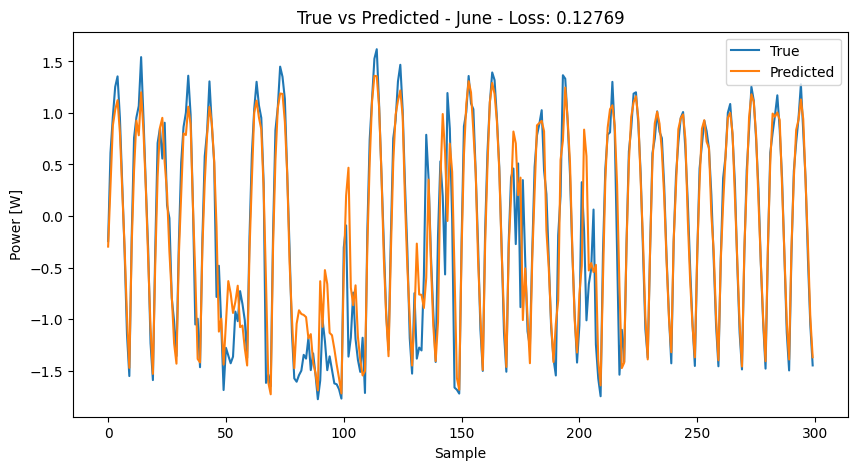

In [52]:
month = 'June'
plt.figure(figsize=(10, 5))
plt.plot(df[df.lr==best_params[0]][df.weight_decay==best_params[1]][df.month==month]['y_test'].values[0], label='True')
plt.plot(df[df.lr==best_params[0]][df.weight_decay==best_params[1]][df.month==month]['y_pred'].values[0], label='Predicted')
plt.title(f'True vs Predicted - {month} - Loss: {df[df.lr==best_params[0]][df.weight_decay==best_params[1]][df.month==month]["test_loss"].values[0]:0.5f}')
plt.xlabel('Sample')
plt.ylabel('Power [W]')
plt.legend()
plt.show()

> Similar results, but the model is less likely to overfit, since it only has one month of data.

### 3. Streaming model, shifting window

> Train a model using a week of data, predict the same week of the next year. Shift the window one day at a time and average the results for the same days. 

In [ ]:
train_year = [2018]
valid_year = 2019

selected_months = [7, 8, 9]

x_train = time_series[(time_series.year.isin(train_year)) & (time_series.month.isin(selected_months))][train_columns].values
y_train = time_series[(time_series.year.isin(train_year)) & (time_series.month.isin(selected_months))]['target'].values

x_valid = time_series[(time_series.year==valid_year) & (time_series.month.isin(selected_months))][train_columns].values
y_valid = time_series[(time_series.year==valid_year) & (time_series.month.isin(selected_months))]['target'].values

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

In [ ]:
TOTAL_TRAIN_SAMPLES = len(x_train)
WINDOW_SIZE = 7*(hour_end-hour_begin) # window of 7 days

N_ARRIVALS_PER_ROUND = 1*(hour_end-hour_begin) # shift by 1 day

TIME_HORIZON = int((TOTAL_TRAIN_SAMPLES-WINDOW_SIZE)/N_ARRIVALS_PER_ROUND)

NUM_EPOCHS = 300

LR_GRID = [1e-2]
SEED_GRID = [1956]

SAVE_PATH = 'scenario3.json'

if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
# DEVICE = 'mps'

print("DEVICE:", DEVICE)

In [ ]:
all_results_dict = dict()

for seed_ in SEED_GRID:
    all_results_dict[seed_] = dict()
    for lr_ in LR_GRID:
        all_results_dict[seed_][lr_] = dict()
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
        torch.manual_seed(seed_)
        
        start_index = 0

        for step in tqdm(range(1, TIME_HORIZON+1)):
            all_results_dict[seed_][lr_][step] = dict()
            # Get the current window of data
            x_train_window = x_train[start_index:start_index+WINDOW_SIZE, :]
            y_train_window = y_train[start_index:start_index+WINDOW_SIZE]
            
            x_mean, x_std = np.mean(x_train_window, axis=0), np.std(x_train_window, axis=0)
            y_mean, y_std = np.mean(y_train_window), np.std(y_train_window)
            
            x_train_window = (x_train_window - x_mean) / x_std
            y_train_window = (y_train_window - y_mean) / y_std
            y_train_window = np.array(y_train_window).reshape(-1, 1)
            
            train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train_window), torch.tensor(y_train_window))
            train_dataloader = DataLoader(train_dataset, batch_size=WINDOW_SIZE, shuffle=True)
            train_iterator = iter(train_dataloader)
            
            # Create the model, optimizer, and trainer
            model = SimpleNN(input_dim=x_train.shape[1], output_dim=1, hidden_dim=5).to(DEVICE)
            
            training_loss_history = []

            optimizer = optim.SGD(
                [param for param in model.parameters() if param.requires_grad],
                lr=lr_,
                momentum=0.9,
                weight_decay=5e-4
            )

            trainer = Trainer(
                model=model,
                criterion=nn.MSELoss(reduction='none').to(DEVICE),
                metric=mse,
                device=DEVICE,
                optimizer=optimizer,
                cast_label=False,
            )
            
            for epoch in range(NUM_EPOCHS):
                # Clear gradients from the previous iteration
                trainer.optimizer.zero_grad()

                ## Training Loss
                try:
                    x_stream, y_stream = next(train_iterator)
                except StopIteration:
                    train_iterator = iter(train_dataloader)
                    x_stream, y_stream = next(train_iterator)
            
                x_stream = x_stream.to(DEVICE).type(torch.float32)
                y_stream = y_stream.to(DEVICE).type(torch.float32)

                # Forward pass
                outs_stream = trainer.model(x_stream)
                loss_stream = trainer.criterion(outs_stream, y_stream).mean()
                loss = loss_stream
                
                training_loss_history.append(loss_stream.detach().cpu().numpy())
            
                # Get gradients w.r.t to parameters
                loss.backward()
                
                # Update the parameters
                trainer.optimizer.step()
                # print(f"Step: {step} | Epoch: {epoch} | Training Loss: {loss:0.3f}")
                
            # Predict the values
            x_valid_window = (x_valid[start_index:start_index+WINDOW_SIZE, :] - x_mean) / x_std
            y_valid_window = (y_valid[start_index:start_index+WINDOW_SIZE] - y_mean) / y_std
            y_valid_window = np.array(y_valid_window).reshape(-1, 1)
            
            x_valid_window = torch.tensor(x_valid_window).to(DEVICE).type(torch.float32)
            y_valid_window = torch.tensor(y_valid_window).to(DEVICE).type(torch.float32)
            
            outs_valid_window = trainer.model(x_valid_window)
            
            # Compute prediction loss
            loss_pred = trainer.criterion(outs_valid_window, y_valid_window).mean()
            
            # Update the start index
            start_index += N_ARRIVALS_PER_ROUND
            
            # save the results
            all_results_dict[seed_][lr_][step] = {'training_loss': training_loss_history,
                                                  'prediction_loss': loss_pred.detach().cpu().numpy().tolist(),
                                                  'outs_valid': outs_valid_window.detach().cpu().numpy(),
                                                  'y_valid': y_valid_window.detach().cpu().numpy()}
            
        
        # Save the results in a json file
        with open(SAVE_PATH, 'w') as f:
            json.dump(all_results_dict, f, default=lambda x: x.tolist())

In [ ]:
# read the results
with open(SAVE_PATH, 'r') as f:
    all_results_dict = json.load(f)

# convert this a df with the columns seed, lr, step, training_loss, prediction_loss, outs_valid, y_valid
df = pd.DataFrame(columns=['seed', 'lr', 'step', 'training_loss', 'prediction_loss', 'outs_valid', 'y_valid'])
for seed in all_results_dict.keys():
    for lr in all_results_dict[seed].keys():
        for step in all_results_dict[seed][lr].keys():
            df = df.append({'seed': seed,
                            'lr': lr,
                            'step': step,
                            'training_loss': all_results_dict[seed][lr][step]['training_loss'],
                            'prediction_loss': all_results_dict[seed][lr][step]['prediction_loss'],
                            'outs_valid': all_results_dict[seed][lr][step]['outs_valid'],
                            'y_valid': all_results_dict[seed][lr][step]['y_valid']}, ignore_index=True)
        
df.head(3)

In [ ]:
seed = '1956'
lr = '0.01'

outs_valid = df[(df.seed == seed) & (df.lr == lr)]['outs_valid'].values
y_valid_values = df[(df.seed == seed) & (df.lr == lr)]['y_valid'].values

In [ ]:
outs_valid = np.array(outs_valid.tolist()).reshape(-1, WINDOW_SIZE)
outs_valid

In [ ]:
y_final = np.full((outs_valid.shape[0], 910), np.nan)

# for each row of outs_valid, fill the corresponding row of y_final shifting by 10 columns each time
for i in range(outs_valid.shape[0]):
    y_final[i, i*(hour_end-hour_begin):i*(hour_end-hour_begin)+WINDOW_SIZE] = outs_valid[i]

In [ ]:
y_final_df = pd.DataFrame(y_final)
y_final_df.shape

In [ ]:
y_final_df.head(3)

In [ ]:
# compute the mean and std of each column
y_final_mean = y_final_df.mean(axis=0)
y_final_std = y_final_df.std(axis=0)

In [ ]:
loss = np.mean((y_final_mean - y_valid[0:910].flatten())**2)
loss

In [ ]:
# plot the mean and std using fill_between of the first 70 columns
plt.figure(figsize=(15, 5))
plt.plot(y_final_mean[70:140], label='Predicted power')
plt.fill_between(np.arange(70, 140), y_final_mean[70:140] - y_final_std[70:140], y_final_mean[70:140] + y_final_std[70:140], alpha=0.3)
plt.plot(np.arange(70, 140),y_valid_values[1], label='True power')
plt.title('Average PV generation over one week')
plt.legend()
plt.show()

> This experiement makes less sense, we compare the online method using a week of data with the offline method using a month of data.

### 4. Train 01.2018 -> predict each month of 2018 with this model

> Train a model using 01.2018, predict each month of 2018 with this model.

In [3]:
# Run experiments

def run_scenario4(lr_, weight_decay_, train_year, test_year, train_month, test_month, NUM_EPOCHS=300):

    ###### Define the model, optimizer, loss function and history
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.manual_seed(random_seed)

    # Create the model, optimizer, and trainer
    # model = SimpleNN(input_dim=len(train_columns), output_dim=1, hidden_dim=5).to(DEVICE)
    model = TwoLayerNN(input_dim=len(train_columns), output_dim=1, hidden_dim1 = 32, hidden_dim2 = 32).to(DEVICE)

    optimizer = optim.SGD(
        [param for param in model.parameters() if param.requires_grad],
        lr=lr_,
        momentum=0.9,
        weight_decay=weight_decay_,
    )

    trainer = Trainer(
        model=model,
        criterion=nn.MSELoss(reduction='none').to(DEVICE),
        metric=mse,
        device=DEVICE,
        optimizer=optimizer,
        cast_label=False,
    )
    
    ###### Define training data
    
    x_train = time_series[(time_series.year.isin(train_year)) & (time_series.month.isin(train_month))][train_columns].values
    y_train = time_series[(time_series.year.isin(train_year)) & (time_series.month.isin(train_month))]['target'].values
    
    x_mean, x_std = np.mean(x_train, axis=0), np.std(x_train, axis=0)
    y_mean, y_std = np.mean(y_train), np.std(y_train)
    
    x_train = (x_train - x_mean) / x_std
    y_train = (y_train - y_mean) / y_std
    y_train = np.array(y_train).reshape(-1, 1)
    
    train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train), torch.tensor(y_train))
    train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
    train_iterator = iter(train_dataloader)
    
    ###### Training loop
    training_loss_history = []
    for epoch in range(NUM_EPOCHS):
    
        # Clear gradients from the previous iteration
        trainer.optimizer.zero_grad()

        # Get next batch of data
        try:
            x_stream, y_stream = next(train_iterator)
        except StopIteration:
            train_iterator = iter(train_dataloader)
            x_stream, y_stream = next(train_iterator)
        x_stream = x_stream.to(DEVICE).type(torch.float32)
        y_stream = y_stream.to(DEVICE).type(torch.float32)

        # Forward pass
        outs_stream = trainer.model(x_stream)
        loss_stream = trainer.criterion(outs_stream, y_stream).mean()
        
        # Store loss value
        training_loss_history.append(loss_stream.detach().cpu().numpy())
    
        # Get gradients w.r.t to parameters
        loss_stream.backward()
        
        # Update the parameters
        trainer.optimizer.step()

    ###### Test the model
    
    x_test = time_series[(time_series.year==test_year) & (time_series.month.isin(test_month))][train_columns].values
    y_test = time_series[(time_series.year==test_year) & (time_series.month.isin(test_month))]['target'].values
    
    x_test = (x_test - x_mean) / x_std
    y_test = (y_test - y_mean) / y_std
    y_test = np.array(y_test).reshape(-1, 1)
    
    y_pred = trainer.model(torch.tensor(x_test).to(DEVICE).type(torch.float32))
    test_loss = trainer.criterion(y_pred, torch.tensor(y_test).to(DEVICE).type(torch.float32)).mean()
    
    # print(f"Test Loss: {test_loss:0.3f}")

    return training_loss_history, y_pred*y_std + y_mean, y_test*y_std + y_mean, test_loss

In [20]:
results = {'lr': {}, 'weight_decay': {}, 'train_year': {}, 'test_year': {}, 'train_month': {}, 'test_month': {}, 'training_loss': {}, 'y_pred': {}, 'y_test': {}, 'test_loss': {}}

for year in tqdm([2014, 2015, 2016, 2017, 2018], position=0, leave=True, desc='Years'):

    train_year = [year]
    test_year = year

    train_month = [1]
    # test_month = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    
    for lr_ in [0.001, 0.01, 0.1]:
        for weight_decay_ in [5e-4, 5e-3, 5e-2]:
            for test_month in [[2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12]]:
                training_loss_history, y_pred, y_test, test_loss = run_scenario4(lr_=lr_, weight_decay_=weight_decay_,   train_year=train_year, test_year=test_year, train_month=train_month, test_month=test_month)
                
                results['lr'][(year, lr_, weight_decay_, test_month[0])] = lr_
                results['weight_decay'][(year, lr_, weight_decay_, test_month[0])] = weight_decay_
                results['train_year'][(year, lr_, weight_decay_, test_month[0])] = train_year
                results['test_year'][(year, lr_, weight_decay_, test_month[0])] = test_year
                results['train_month'][(year, lr_, weight_decay_, test_month[0])] = train_month
                results['test_month'][(year, lr_, weight_decay_, test_month[0])] = test_month[0]
                results['training_loss'][(year, lr_, weight_decay_, test_month[0])] = training_loss_history
                results['y_pred'][(year, lr_, weight_decay_, test_month[0])] = y_pred.detach().cpu().numpy()
                results['y_test'][(year, lr_, weight_decay_, test_month[0])] = y_test
                results['test_loss'][(year, lr_, weight_decay_, test_month[0])] = test_loss.detach().cpu().numpy()
                
with open('scenario4_results.pkl', 'wb') as f:
    pickle.dump(results, f)

Years: 100%|██████████| 5/5 [03:09<00:00, 37.91s/it]


In [21]:
with open('scenario4_results.pkl', 'rb') as f:
    results = pickle.load(f)

df4 = pd.DataFrame.from_dict(results).reset_index(drop=True)

In [22]:
df4.groupby(['lr', 'weight_decay'])['test_loss'].mean()

lr     weight_decay
0.001  0.0005           1.498298
       0.0050           1.475781
       0.0500           1.364936
0.010  0.0005          13.197128
       0.0050          11.064708
       0.0500           2.055658
0.100  0.0005          53.750271
       0.0050          21.079510
       0.0500           1.976413
Name: test_loss, dtype: float64

In [23]:
best_params = df4.groupby(['lr', 'weight_decay'])['test_loss'].mean().idxmin()
print(f'Best Learning Rate: {best_params[0]} | Best Weight Decay: {best_params[1]}')

print(f'Average test loss (5y): {df4[df4.lr==best_params[0]][df4.weight_decay==best_params[1]]["test_loss"].mean():.3f} ± {df4[df4.lr==best_params[0]][df4.weight_decay==best_params[1]]["test_loss"].std():.3f}')

Best Learning Rate: 0.001 | Best Weight Decay: 0.05
Average test loss (5y): 1.365 ± 0.821


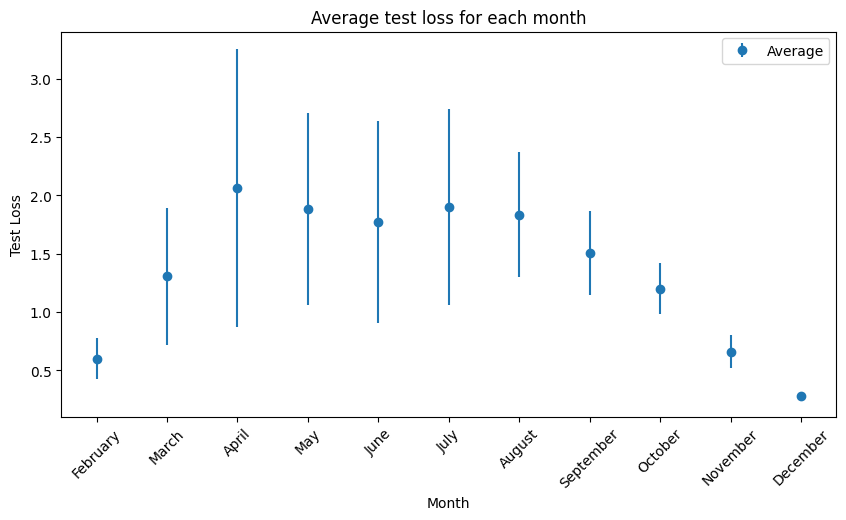

In [24]:
plt.figure(figsize=(10, 5))
# plt.bar(np.arange(2, 13), df4[df4.lr==best_params[0]][df4.weight_decay==best_params[1]].groupby('test_month')['test_loss'].mean())
plt.errorbar(np.arange(2, 13), df4[df4.lr==best_params[0]][df4.weight_decay==best_params[1]].groupby('test_month')['test_loss'].mean(), yerr=df4[df4.lr==best_params[0]][df4.weight_decay==best_params[1]].groupby('test_month')['test_loss'].std(), fmt='o', label='Average')
plt.title('Average test loss for each month')
plt.xticks(np.arange(2, 13), [months_name[i] for i in np.arange(2, 13)], rotation=45)
plt.legend()
plt.xlabel('Month')
plt.ylabel('Test Loss')
plt.show()

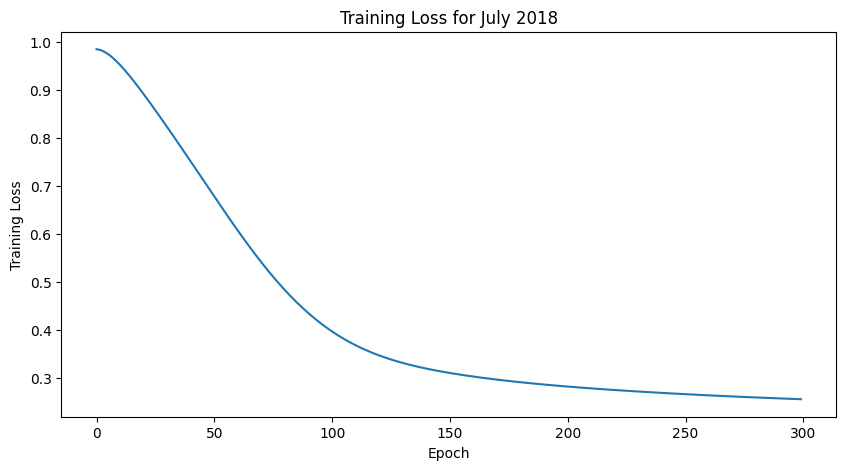

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(df4[(df4.lr==best_params[0]) & (df4.weight_decay==best_params[1]) & (df4.test_month==7) & (df4.test_year==2018)]['training_loss'].values[0])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss for July 2018')
plt.show()

### 5. Train 01.2018 -> predict 02.2018, add 02.2018 to the training set -> predict 03.2018 ...

> To take into account the new data, we add the month to the training set and keep the old months (increasing the training set size at the end of each month). We predict the following month with the model trained on the previous months.

In [32]:
def run_scenario5(lr_, weight_decay_, train_year, test_year, selected_months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], NUM_EPOCHS=300):

    ###### Print current lr
    # print(f"\nLR: {lr_}")
    
    ###### Define the model, optimizer, loss function and history
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.manual_seed(random_seed)

    # Create the model, optimizer, and trainer
    # model = SimpleNN(input_dim=len(train_columns), output_dim=1, hidden_dim=5).to(DEVICE)
    model = TwoLayerNN(input_dim=len(train_columns), output_dim=1, hidden_dim1 = 32, hidden_dim2 = 32).to(DEVICE)

    optimizer = optim.SGD(
        [param for param in model.parameters() if param.requires_grad],
        lr=lr_,
        momentum=0.9,
        weight_decay=weight_decay_,
    )

    trainer = Trainer(
        model=model,
        criterion=nn.MSELoss(reduction='none').to(DEVICE),
        metric=mse,
        device=DEVICE,
        optimizer=optimizer,
        cast_label=False,
    )
    
    y_pred_month_history = []
    y_test_month_history = []
    loss_test_month_history = []
    
    # loop over the months to use as training data
    for month in selected_months[:-1]:
        
        ###### Define training data
        x_train_month = time_series[(time_series.year.isin(train_year)) & (time_series.month.isin(np.arange(1, month+1, 1)))][train_columns].values
        y_train_month = time_series[(time_series.year.isin(train_year)) & (time_series.month.isin(np.arange(1, month+1, 1)))]['target'].values
        
        x_mean, x_std = np.mean(x_train_month, axis=0), np.std(x_train_month, axis=0)
        y_mean, y_std = np.mean(y_train_month), np.std(y_train_month)
        
        x_train_month = (x_train_month - x_mean) / x_std
        y_train_month = (y_train_month - y_mean) / y_std
        y_train_month = np.array(y_train_month).reshape(-1, 1)
    
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train_month), torch.tensor(y_train_month))
        train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
        train_iterator = iter(train_dataloader)
    
        ###### Training loop
        training_loss_history = []
        for epoch in range(NUM_EPOCHS):
        
            # Clear gradients from the previous iteration
            trainer.optimizer.zero_grad()

            # Get next batch of data
            try:
                x_stream, y_stream = next(train_iterator)
            except StopIteration:
                train_iterator = iter(train_dataloader)
                x_stream, y_stream = next(train_iterator)
            x_stream = x_stream.to(DEVICE).type(torch.float32)
            y_stream = y_stream.to(DEVICE).type(torch.float32)

            # Forward pass
            outs_stream = trainer.model(x_stream)
            loss_stream = trainer.criterion(outs_stream, y_stream).mean()
            
            # Store loss value
            training_loss_history.append(loss_stream.detach().cpu().numpy())
        
            # Get gradients w.r.t to parameters
            loss_stream.backward()
            
            # Update the parameters
            trainer.optimizer.step()
    
        # Print training loss value
        # print(f'Training Loss: {loss_stream:0.3f}')
    
        ###### Test the model on the next month
        x_test_month = time_series[(time_series.year==test_year) & (time_series.month==month+1)][train_columns].values
        y_test_month = time_series[(time_series.year==test_year) & (time_series.month==month+1)]['target'].values
        
        x_test_month = (x_test_month - x_mean) / x_std
        y_test_month = (y_test_month - y_mean) / y_std
        y_test_month = np.array(y_test_month).reshape(-1, 1)
        
        y_pred_month = trainer.model(torch.tensor(x_test_month).to(DEVICE).type(torch.float32))
        loss_test_month = trainer.criterion(y_pred_month, torch.tensor(y_test_month).to(DEVICE).type(torch.float32)).mean()
        
        y_pred_month_history.append(y_pred_month.detach().cpu().numpy()*y_std + y_mean)
        y_test_month_history.append(y_test_month*y_std + y_mean)
        loss_test_month_history.append(loss_test_month.detach().cpu().numpy())
    
        # print(f"Test Loss: {loss_test_month:0.3f}")
        
    return training_loss_history, y_pred_month_history, y_test_month_history, loss_test_month_history

In [33]:
results = {'lr': {}, 'weight_decay_':{}, 'train_year': {}, 'test_year': {}, 'training_loss': {}, 'y_pred': {}, 'y_test': {}, 'test_loss': {}}

for year in tqdm([2014, 2015, 2016, 2017, 2018], position=0, leave=True, desc='Years'):

    train_year = [year]
    test_year = year

    for lr_ in [0.001, 0.01, 0.1]:
        for weight_decay_ in [5e-4, 5e-3, 5e-2]:
            training_loss_history, y_pred, y_test, test_loss = run_scenario5(lr_=lr_, weight_decay_=weight_decay_, train_year=train_year, test_year=test_year)
            
            results['lr'][(year, lr_, weight_decay_)] = lr_
            results['weight_decay_'][(year, lr_, weight_decay_)] = weight_decay_
            results['train_year'][(year, lr_, weight_decay_)] = train_year
            results['test_year'][(year, lr_, weight_decay_)] = test_year
            results['training_loss'][(year, lr_, weight_decay_)] = training_loss_history
            results['y_pred'][(year, lr_, weight_decay_)] = y_pred
            results['y_test'][(year, lr_, weight_decay_)] = y_test
            results['test_loss'][(year, lr_, weight_decay_)] = test_loss
            
with open('scenario5_results.pkl', 'wb') as f:
    pickle.dump(results, f)

Years: 100%|██████████| 5/5 [03:56<00:00, 47.23s/it]


In [34]:
with open('scenario5_results.pkl', 'rb') as f:
    results = pickle.load(f)

df5 = pd.DataFrame.from_dict(results).reset_index(drop=True)

# add column mean_test_loss
df5['mean_test_loss'] = df5['test_loss'].apply(lambda x: np.mean(x))
df5

,lr,weight_decay_,train_year,test_year,training_loss,y_pred,y_test,test_loss,mean_test_loss
0,0.001,0.0005,[2014],2014,"[0.12242916, 0.11694706, 0.10060112, 0.1392033...","[[[10.027031], [16.274424], [23.974024], [26.8...","[[[6.823986227624879], [13.397230516795288], [...","[0.47952363, 0.27822033, 0.17818551, 0.2997394...",0.196082
1,0.001,0.0050,[2014],2014,"[0.12283526, 0.117403515, 0.10106051, 0.140017...","[[[9.99506], [16.25196], [23.929525], [26.8021...","[[[6.823986227624879], [13.397230516795288], [...","[0.48013234, 0.28178865, 0.17674515, 0.2986187...",0.195786
2,0.001,0.0500,[2014],2014,"[0.1289636, 0.12549786, 0.10944986, 0.14797823...","[[[9.812568], [16.113058], [23.542345], [26.61...","[[[6.823986227624879], [13.397230516795288], [...","[0.48469695, 0.31257254, 0.18703298, 0.300563,...",0.200332
3,0.010,0.0005,[2014],2014,"[0.112242356, 0.103264764, 0.08792846, 0.12051...","[[[12.338573], [17.994143], [23.20803], [25.66...","[[[6.823986227624879], [13.397230516795288], [...","[0.55378866, 0.23387077, 0.18255949, 0.3071186...",0.201382
4,0.010,0.0050,[2014],2014,"[0.1141254, 0.10740328, 0.09261176, 0.12971672...","[[[12.600267], [17.864857], [23.189617], [25.5...","[[[6.823986227624879], [13.397230516795288], [...","[0.51131725, 0.21289511, 0.1832521, 0.29490086...",0.188335
5,0.010,0.0500,[2014],2014,"[0.12768736, 0.12556826, 0.10992944, 0.1494419...","[[[11.999714], [18.912992], [24.352802], [25.6...","[[[6.823986227624879], [13.397230516795288], [...","[0.4260331, 0.27279034, 0.1930303, 0.29415825,...",0.189182
6,0.100,0.0005,[2014],2014,"[0.09048945, 0.09217555, 0.076684654, 0.102985...","[[[9.715769], [19.958208], [22.405561], [21.42...","[[[6.823986227624879], [13.397230516795288], [...","[1.6225176, 0.49620727, 0.23345754, 0.35704044...",0.345963
7,0.100,0.0050,[2014],2014,"[0.11633828, 0.10496793, 0.09109348, 0.1282075...","[[[10.769281], [16.446026], [19.44989], [22.28...","[[[6.823986227624879], [13.397230516795288], [...","[1.4188101, 0.29197347, 0.15333605, 0.3154519,...",0.278226
8,0.100,0.0500,[2014],2014,"[0.12848121, 0.12732637, 0.1146837, 0.15169854...","[[[11.587548], [18.222399], [23.12173], [25.16...","[[[6.823986227624879], [13.397230516795288], [...","[0.44144657, 0.38795996, 0.19049823, 0.3022683...",0.202581
9,0.001,0.0005,[2015],2015,"[0.110469125, 0.11921865, 0.10280943, 0.106386...","[[[8.729511], [10.488321], [16.467651], [20.29...","[[[5.5254920739104705], [8.72059047021699], [1...","[0.74514025, 0.4734809, 0.20758477, 0.21326503...",0.219892


In [35]:
df5.groupby(['lr', 'weight_decay_'])['mean_test_loss'].mean()

lr     weight_decay_
0.001  0.0005           0.215670
       0.0050           0.215441
       0.0500           0.220116
0.010  0.0005           0.204402
       0.0050           0.194996
       0.0500           0.199532
0.100  0.0005           0.352627
       0.0050           0.273982
       0.0500           0.210819
Name: mean_test_loss, dtype: float32

In [36]:
best_params = df5.groupby(['lr', 'weight_decay_'])['mean_test_loss'].mean().idxmin()
print(f'Best Learning Rate: {best_params[0]} | Best Weight Decay: {best_params[1]}')

print(f'Average test loss (5y): {df5[df5.lr==best_params[0]][df5.weight_decay_==best_params[1]]["mean_test_loss"].mean():.3f} ± {df5[df5.lr==best_params[0]][df5.weight_decay_==best_params[1]]["mean_test_loss"].std():.3f}')

Best Learning Rate: 0.01 | Best Weight Decay: 0.005
Average test loss (5y): 0.195 ± 0.012


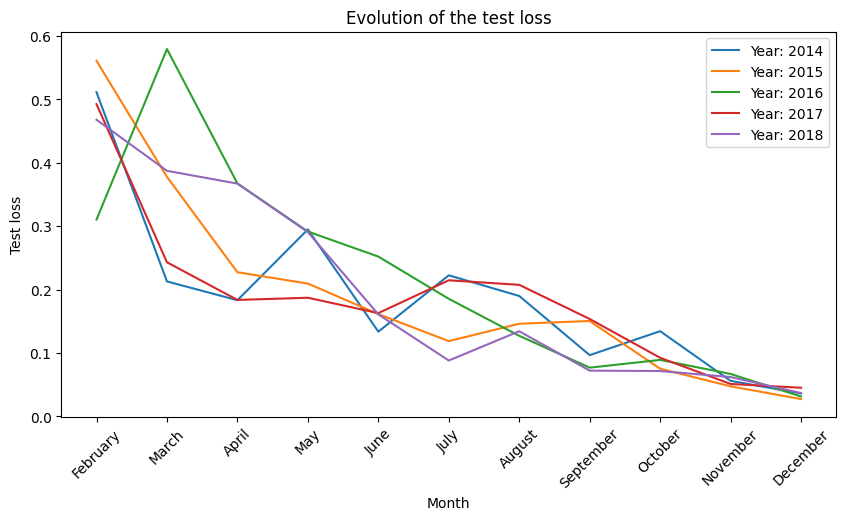

In [37]:
plt.figure(figsize=(10, 5))
for year in [2014, 2015, 2016, 2017, 2018]:
    plt.plot(np.arange(2, 13), df5[(df5.lr==best_params[0]) & (df5.weight_decay_==best_params[1]) & (df5.test_year==year)]['test_loss'].values[0], label=f'Year: {year}')
    plt.legend()
plt.title('Evolution of the test loss')
plt.xticks(np.arange(2, 13), [months_name[i] for i in np.arange(2, 13)], rotation=45)
plt.xlabel('Month')
plt.ylabel('Test loss')
plt.show()

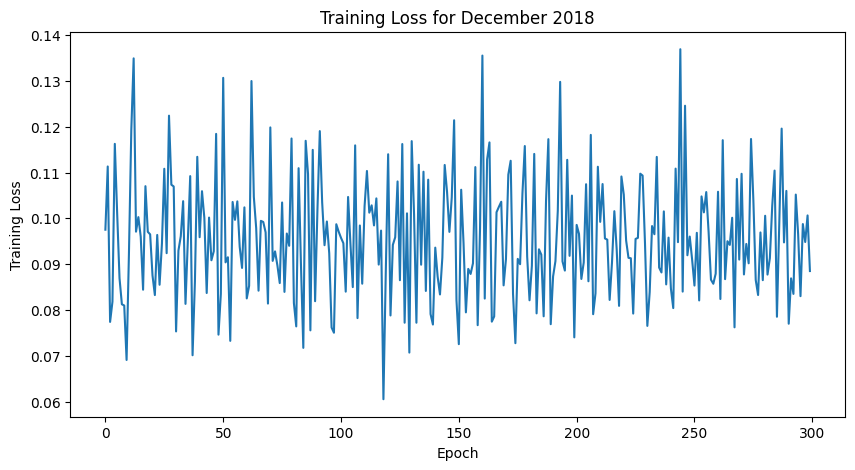

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(df5[(df5.lr==best_params[0]) & (df5.weight_decay_==best_params[1]) & (df5.test_year==2018)]['training_loss'].values[0])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss for December 2018')
plt.show()

### 6. Train 01.2018 -> predict 02.2018, train 02.2018 -> predict 03.2018 ...

> We train a model for each month and predict the following month of the same year.

In [138]:
# Run experiments

def run_scenario6(lr_, weight_decay_, train_year, test_year, selected_months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], NUM_EPOCHS=300):

    ###### Print current lr
    # print(f"\nLR: {lr_}")
    
    ###### Define the model, optimizer, loss function and history
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.manual_seed(random_seed)

    # Create the model, optimizer, and trainer
    # model = SimpleNN(input_dim=len(train_columns), output_dim=1, hidden_dim=5).to(DEVICE)
    model = TwoLayerNN(input_dim=len(train_columns), output_dim=1, hidden_dim1 = 32, hidden_dim2 = 32).to(DEVICE)

    optimizer = optim.SGD(
        [param for param in model.parameters() if param.requires_grad],
        lr=lr_,
        momentum=0.9,
        weight_decay=weight_decay_, 
    )

    trainer = Trainer(
        model=model,
        criterion=nn.MSELoss(reduction='none').to(DEVICE),
        metric=mse,
        device=DEVICE,
        optimizer=optimizer,
        cast_label=False,
    )
    
    y_pred_month_history = []
    y_test_month_history = []
    loss_test_month_history = []
    
    # loop over the months to use as training data
    for month in selected_months[:-1]:
    
        ###### Define training data
        x_train_month = time_series[(time_series.year.isin(train_year)) & (time_series.month == month)][train_columns].values
        y_train_month = time_series[(time_series.year.isin(train_year)) & (time_series.month == month)]['target'].values
        
        x_mean, x_std = np.mean(x_train_month, axis=0), np.std(x_train_month, axis=0)
        y_mean, y_std = np.mean(y_train_month), np.std(y_train_month)
        
        x_train_month = (x_train_month - x_mean) / x_std
        y_train_month = (y_train_month - y_mean) / y_std
        y_train_month = np.array(y_train_month).reshape(-1, 1)
    
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train_month), torch.tensor(y_train_month))
        train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
        train_iterator = iter(train_dataloader)
    
        ###### Training loop
        training_loss_history = []
        for epoch in range(NUM_EPOCHS):
        
            # Clear gradients from the previous iteration
            trainer.optimizer.zero_grad()

            # Get next batch of data
            try:
                x_stream, y_stream = next(train_iterator)
            except StopIteration:
                train_iterator = iter(train_dataloader)
                x_stream, y_stream = next(train_iterator)
            x_stream = x_stream.to(DEVICE).type(torch.float32)
            y_stream = y_stream.to(DEVICE).type(torch.float32)

            # Forward pass
            outs_stream = trainer.model(x_stream)
            loss_stream = trainer.criterion(outs_stream, y_stream).mean()
            
            # Store loss value
            training_loss_history.append(loss_stream.detach().cpu().numpy())
        
            # Get gradients w.r.t to parameters
            loss_stream.backward()
            
            # Update the parameters
            trainer.optimizer.step()
    
        ###### Test the model on the next month
        x_test_month = time_series[(time_series.year==test_year) & (time_series.month == month+1)][train_columns].values
        y_test_month = time_series[(time_series.year==test_year) & (time_series.month == month+1)]['target'].values
        
        x_test_month = (x_test_month - x_mean) / x_std
        y_test_month = (y_test_month - y_mean) / y_std
        y_test_month = np.array(y_test_month).reshape(-1, 1)
        
        y_pred_month = trainer.model(torch.tensor(x_test_month).to(DEVICE).type(torch.float32))
        loss_test_month = trainer.criterion(y_pred_month, torch.tensor(y_test_month).to(DEVICE).type(torch.float32)).mean()
    
        # print(f"Validation Loss: {loss_test_month:0.3f}")
        
        y_pred_month_history.append(y_pred_month.detach().cpu().numpy()*y_std + y_mean)
        y_test_month_history.append(y_test_month*y_std + y_mean)
        loss_test_month_history.append(loss_test_month.detach().cpu().numpy())

    return training_loss_history, y_pred_month_history, y_test_month_history, loss_test_month_history

In [139]:
results = {'lr': {}, 'weight_decay': {}, 'train_year': {}, 'test_year': {}, 'training_loss': {}, 'y_pred': {}, 'y_test': {}, 'test_loss': {}}

for year in tqdm([2014, 2015, 2016, 2017, 2018], position=0, leave=True, desc='Years'):

    train_year = [year]
    test_year = year

    for lr_ in [0.001, 0.01, 0.1]:
        for weight_decay_ in [5e-4, 5e-3, 5e-2]:
            training_loss_history, y_pred, y_test, test_loss = run_scenario6(lr_=lr_, weight_decay_=weight_decay_, train_year=train_year, test_year=test_year)
            
            results['lr'][(year, lr_, weight_decay_)] = lr_
            results['weight_decay'][(year, lr_, weight_decay_)] = weight_decay_
            results['train_year'][(year, lr_, weight_decay_)] = train_year
            results['test_year'][(year, lr_, weight_decay_)] = test_year
            results['training_loss'][(year, lr_, weight_decay_)] = training_loss_history
            results['y_pred'][(year, lr_, weight_decay_)] = y_pred
            results['y_test'][(year, lr_, weight_decay_)] = y_test
            results['test_loss'][(year, lr_, weight_decay_)] = test_loss
            
with open('scenario6_results.pkl', 'wb') as f:
    pickle.dump(results, f)

Years: 100%|██████████| 5/5 [02:59<00:00, 35.86s/it]


In [140]:
with open('scenario6_results.pkl', 'rb') as f:
    results = pickle.load(f)

df6 = pd.DataFrame.from_dict(results).reset_index(drop=True)

# add column mean_test_loss
df6['mean_test_loss'] = df6['test_loss'].apply(lambda x: np.mean(x))
df6.sample(3)

,lr,weight_decay,train_year,test_year,y_pred,y_test,test_loss,mean_test_loss
34,0.10,0.0050,[2017],2017,"[[[8.861454], [24.73747], [45.988136], [56.989...","[[[15.22495256448771], [33.77693436157554], [4...","[0.79945886, 0.312583, 0.19777098, 0.24471623,...",0.540618
33,0.10,0.0005,[2017],2017,"[[[7.7351637], [22.481825], [48.040573], [38.5...","[[[15.22495256448771], [33.77693436157554], [4...","[0.83028406, 0.6339413, 0.43253127, 0.5413628,...",1.275737
13,0.01,0.0050,[2015],2015,"[[[10.4722], [15.319833], [17.386683], [19.177...","[[[5.5254920739104705], [8.72059047021699], [1...","[0.5609578, 0.34943837, 0.55170685, 1.0922574,...",0.491222


In [141]:
df6.groupby(['lr', 'weight_decay'])['mean_test_loss'].mean()

lr     weight_decay
0.001  0.0005          0.269060
       0.0050          0.264429
       0.0500          0.248110
0.010  0.0005          0.444853
       0.0050          0.409407
       0.0500          0.253036
0.100  0.0005          1.371684
       0.0050          0.707269
       0.0500          0.262910
Name: mean_test_loss, dtype: float32

In [142]:
best_params = df6.groupby(['lr', 'weight_decay'])['mean_test_loss'].mean().idxmin()
print(f'Best Learning Rate: {best_params[0]} | Best Weight Decay: {best_params[1]}')

print(f'Average test loss (5y): {df6[df6.lr==best_params[0]][df6.weight_decay==best_params[1]]["mean_test_loss"].mean():.3f} ± {df6[df6.lr==best_params[0]][df6.weight_decay==best_params[1]]["mean_test_loss"].std():.3f}')

Best Learning Rate: 0.001 | Best Weight Decay: 0.05
Average test loss (5y): 0.248 ± 0.016


In [143]:
df6[(df6.lr==best_params[0]) & (df6.weight_decay==best_params[1])]

,lr,weight_decay,train_year,test_year,y_pred,y_test,test_loss,mean_test_loss
2,0.001,0.05,[2014],2014,"[[[9.812568], [16.113058], [23.542345], [26.61...","[[[6.823986227624879], [13.397230516795288], [...","[0.48469695, 0.23121746, 0.15332323, 0.2937673...",0.222580
11,0.001,0.05,[2015],2015,"[[[8.399813], [10.691908], [16.487888], [20.37...","[[[5.5254920739104705], [8.72059047021699], [1...","[0.7493359, 0.37847367, 0.2078817, 0.2723669, ...",0.250588
20,0.001,0.05,[2016],2016,"[[[8.220125], [16.858292], [28.318462], [27.24...","[[[7.436691793298497], [18.179829456913502], [...","[0.4027729, 0.8313328, 0.251524, 0.31766704, 0...",0.266756
29,0.001,0.05,[2017],2017,"[[[6.5725536], [15.84778], [32.241337], [41.21...","[[[15.22495256448771], [33.77693436157554], [4...","[0.8132111, 0.17533171, 0.1676762, 0.20678349,...",0.248379
38,0.001,0.05,[2018],2018,"[[[7.146555], [12.449159], [15.619535], [21.84...","[[[4.703835373160635], [6.010389335678687], [1...","[0.5560264, 0.2682357, 0.26985866, 0.6018029, ...",0.252248


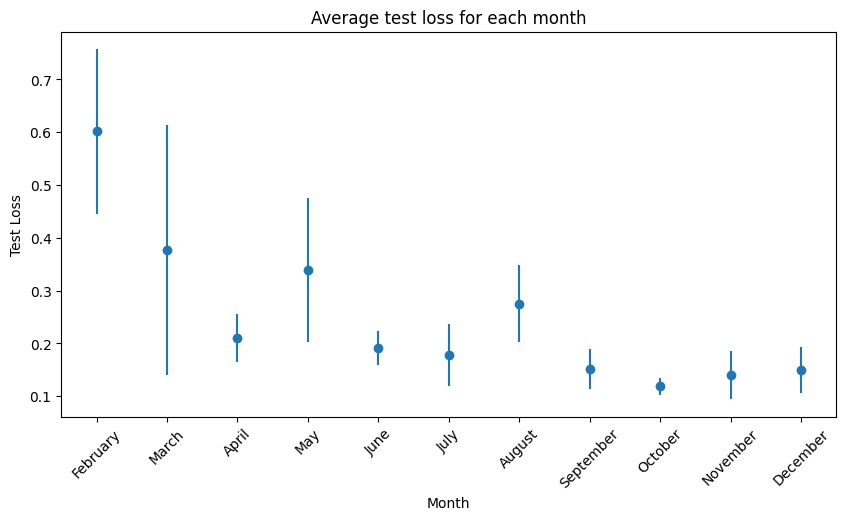

In [144]:
# pass test loss to an array
test_losses = np.full((5, 11), np.nan)
for ind, year in enumerate([2014, 2015, 2016, 2017, 2018]):
    # create a 5x11 array with the test loss for each month
    test_loss = np.array(df6[(df6.lr==best_params[0]) & (df6.weight_decay==best_params[1]) & (df6.test_year==year)]['test_loss'].values[0])
    test_losses[ind, :test_loss.shape[0]] = test_loss.flatten()
    
plt.figure(figsize=(10, 5))
plt.errorbar(np.arange(2, 13), test_losses.mean(axis=0), yerr=test_losses.std(axis=0), fmt='o')
plt.title('Average test loss for each month')
plt.xticks(np.arange(2, 13), [months_name[i] for i in np.arange(2, 13)], rotation=45)
plt.xlabel('Month')
plt.ylabel('Test Loss')
plt.show()

> The results are the worst when there is a notable change in the month weather. We can see that the results are less good when training with April and predicting May. For similar months, (e.g. May -> June) the results are better.

### 7. Train using 2 months, predict the following month

In [120]:
# Run experiments
def run_scenario7(lr_, weight_decay_, train_year, test_year, selected_months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], NUM_EPOCHS=300):
            
    ###### Print current seed and lr
    # print(f"LR: {lr_}")
    
    ###### Define the model, optimizer, loss function and history
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.manual_seed(random_seed)

    # Create the model, optimizer, and trainer
    # model = SimpleNN(input_dim=len(train_columns), output_dim=1, hidden_dim=5).to(DEVICE)
    model = TwoLayerNN(input_dim=len(train_columns), output_dim=1, hidden_dim1 = 32, hidden_dim2 = 32).to(DEVICE)

    optimizer = optim.SGD(
        [param for param in model.parameters() if param.requires_grad],
        lr=lr_,
        momentum=0.9,
        weight_decay=weight_decay_, 
    )

    trainer = Trainer(
        model=model,
        criterion=nn.MSELoss(reduction='none').to(DEVICE),
        metric=mse,
        device=DEVICE,
        optimizer=optimizer,
        cast_label=False,
    )
    
    # loop over the months to use as training data
    y_pred_month_history = []
    y_test_month_history = []
    loss_test_month_history = []
    
    for month in selected_months[:-2]:
    
        ###### Define training data
        x_train_month = time_series[(time_series.year.isin(train_year)) & (time_series.month.isin([month, month+1]))][train_columns].values
        y_train_month = time_series[(time_series.year.isin(train_year)) & (time_series.month.isin([month, month+1]))]['target'].values
        
        x_mean, x_std = np.mean(x_train_month, axis=0), np.std(x_train_month, axis=0)
        y_mean, y_std = np.mean(y_train_month), np.std(y_train_month)
        
        x_train_month = (x_train_month - x_mean) / x_std
        y_train_month = (y_train_month - y_mean) / y_std
        y_train_month = np.array(y_train_month).reshape(-1, 1)
    
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train_month), torch.tensor(y_train_month))
        train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
        train_iterator = iter(train_dataloader)
    
        ###### Training loop
        training_loss_history = []
        for epoch in range(NUM_EPOCHS):
        
            # Clear gradients from the previous iteration
            trainer.optimizer.zero_grad()

            # Get next batch of data
            try:
                x_stream, y_stream = next(train_iterator)
            except StopIteration:
                train_iterator = iter(train_dataloader)
                x_stream, y_stream = next(train_iterator)
            x_stream = x_stream.to(DEVICE).type(torch.float32)
            y_stream = y_stream.to(DEVICE).type(torch.float32)

            # Forward pass
            outs_stream = trainer.model(x_stream)
            loss_stream = trainer.criterion(outs_stream, y_stream).mean()
            
            # Store loss value
            training_loss_history.append(loss_stream.detach().cpu().numpy())
        
            # Get gradients w.r.t to parameters
            loss_stream.backward()
            
            # Update the parameters
            trainer.optimizer.step()
    
        # Print training loss value
        # print(f'Training Loss: {loss_stream:0.3f}')
    
        ###### Test the model on the next month
        x_test_month = time_series[(time_series.year==test_year) & (time_series.month.isin([month+2]))][train_columns].values
        y_test_month = time_series[(time_series.year==test_year) & (time_series.month.isin([month+2]))]['target'].values
        
        x_test_month = (x_test_month - x_mean) / x_std
        y_test_month = (y_test_month - y_mean) / y_std
        
        y_test_month = np.array(y_test_month).reshape(-1, 1)
        
        y_pred_month = trainer.model(torch.tensor(x_test_month).to(DEVICE).type(torch.float32))
        loss_test_month = trainer.criterion(y_pred_month, torch.tensor(y_test_month).to(DEVICE).type(torch.float32)).mean()
    
        # print(f"Validation Loss: {loss_test_month:0.3f}")

        y_pred_month_history.append(y_pred_month.detach().cpu().numpy()*y_std + y_mean)
        y_test_month_history.append(y_test_month*y_std + y_mean)
        loss_test_month_history.append(loss_test_month.detach().cpu().numpy())
        
        
    return training_loss_history, y_pred_month_history, y_test_month_history, loss_test_month_history

In [121]:
results = {'lr': {}, 'weight_decay': {}, 'train_year': {}, 'test_year': {}, 'training_loss': {}, 'y_pred': {}, 'y_test': {}, 'test_loss': {}}

for year in tqdm([2014, 2015, 2016, 2017, 2018], position=0, leave=True, desc='Years'):

    train_year = [year]
    test_year = year

    for lr_ in [0.001, 0.01, 0.1]:
        for weight_decay_ in [5e-4, 5e-3, 5e-2]:
            training_loss_history, y_pred, y_test, test_loss = run_scenario7(lr_=lr_, weight_decay_=weight_decay_, train_year=train_year, test_year=test_year)
            
            results['lr'][(year, lr_, weight_decay_)] = lr_
            results['weight_decay'][(year, lr_, weight_decay_)] = weight_decay_
            results['train_year'][(year, lr_, weight_decay_)] = train_year
            results['test_year'][(year, lr_, weight_decay_)] = test_year
            results['training_loss'][(year, lr_, weight_decay_)] = training_loss_history
            results['y_pred'][(year, lr_, weight_decay_)] = y_pred
            results['y_test'][(year, lr_, weight_decay_)] = y_test
            results['test_loss'][(year, lr_, weight_decay_)] = test_loss
            
with open('scenario7_results.pkl', 'wb') as f:
    pickle.dump(results, f)

Years: 100%|██████████| 5/5 [02:36<00:00, 31.32s/it]


In [122]:
with open('scenario7_results.pkl', 'rb') as f:
    results = pickle.load(f)

df7 = pd.DataFrame.from_dict(results).reset_index(drop=True)

# add column mean_test_loss
df7['mean_test_loss'] = df7['test_loss'].apply(lambda x: np.mean(x))
df7.sample(3)

,lr,weight_decay,train_year,test_year,y_pred,y_test,test_loss,mean_test_loss
5,0.010,0.0500,[2014],2014,"[[[18.635094], [28.67563], [24.724243], [46.33...","[[[15.884267369320998], [11.806632110054904], ...","[0.30306327, 0.1581138, 0.26491722, 0.12837353...",0.174690
17,0.100,0.0500,[2015],2015,"[[[20.322998], [41.446037], [31.538208], [28.3...","[[[27.353259200443755], [17.914618784295154], ...","[0.54508907, 0.22452113, 0.21506375, 0.1441932...",0.190183
18,0.001,0.0005,[2016],2016,"[[[11.144691], [26.145987], [52.744827], [71.2...","[[[21.413553326692703], [53.589531031864176], ...","[0.89950866, 0.3178953, 0.34684548, 0.24106827...",0.251875


In [123]:
df7.groupby(['lr', 'weight_decay'])['mean_test_loss'].mean()

lr     weight_decay
0.001  0.0005          0.213273
       0.0050          0.211477
       0.0500          0.205548
0.010  0.0005          0.242502
       0.0050          0.215015
       0.0500          0.187099
0.100  0.0005          0.513340
       0.0050          0.333993
       0.0500          0.214633
Name: mean_test_loss, dtype: float32

In [124]:
df7.groupby(['lr', 'weight_decay'])['mean_test_loss'].mean()
best_params = df7.groupby(['lr', 'weight_decay'])['mean_test_loss'].mean().idxmin()
print(f'Best Learning Rate: {best_params[0]} | Best Weight Decay: {best_params[1]}')

print(f'Average test loss (5y): {df7[df7.lr==best_params[0]][df7.weight_decay==best_params[1]]["mean_test_loss"].mean():.3f} ± {df7[df7.lr==best_params[0]][df7.weight_decay==best_params[1]]["mean_test_loss"].std():.3f}')

Best Learning Rate: 0.01 | Best Weight Decay: 0.05
Average test loss (5y): 0.187 ± 0.024


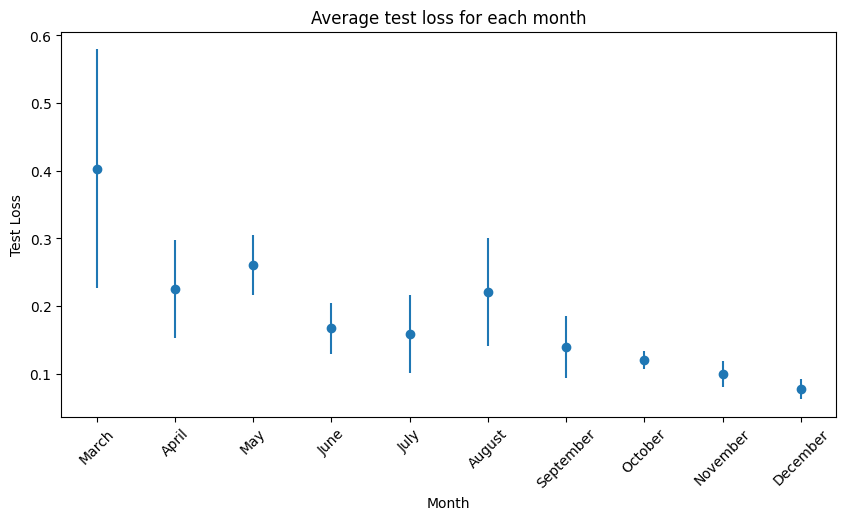

In [127]:
# pass test loss to an array
test_losses = np.full((5, 10), np.nan)
for ind, year in enumerate([2014, 2015, 2016, 2017, 2018]):
    test_loss = np.array(df7[(df7.lr==best_params[0]) & (df7.weight_decay==best_params[1]) & (df7.test_year==year)]['test_loss'].values[0])
    test_losses[ind, :test_loss.shape[0]] = test_loss.flatten()
    
plt.figure(figsize=(10, 5))
plt.errorbar(np.arange(3, 13), test_losses.mean(axis=0), yerr=test_losses.std(axis=0), fmt='o')
plt.title('Average test loss for each month')
plt.xticks(np.arange(3, 13), [months_name[i] for i in np.arange(3, 13)], rotation=45)
plt.xlabel('Month')
plt.ylabel('Test Loss')
plt.show()

### 8. Train using prediction month of previous years

In [128]:
# Run experiments
def run_scenario8(lr_, weight_decay_, train_year, test_year, selected_months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], NUM_EPOCHS=300):
            
    ###### Print current seed and lr
    # print(f"LR: {lr_}")
    
    ###### Define the model, optimizer, loss function and history
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.manual_seed(random_seed)

    # Create the model, optimizer, and trainer
    # model = SimpleNN(input_dim=len(train_columns), output_dim=1, hidden_dim=5).to(DEVICE)
    model = TwoLayerNN(input_dim=len(train_columns), output_dim=1, hidden_dim1 = 32, hidden_dim2 = 32).to(DEVICE)

    optimizer = optim.SGD(
        [param for param in model.parameters() if param.requires_grad],
        lr=lr_,
        momentum=0.9,
        weight_decay=weight_decay_, 
    )

    trainer = Trainer(
        model=model,
        criterion=nn.MSELoss(reduction='none').to(DEVICE),
        metric=mse,
        device=DEVICE,
        optimizer=optimizer,
        cast_label=False,
    )
    
    # loop over the months to use as training data
    y_pred_month_history = []
    y_test_month_history = []
    loss_test_month_history = []
    
    for month in selected_months:
    
        ###### Define training data
        x_train_month = time_series[(time_series.year.isin(train_year)) & (time_series.month.isin([month]))][train_columns].values
        y_train_month = time_series[(time_series.year.isin(train_year)) & (time_series.month.isin([month]))]['target'].values
        
        x_mean, x_std = np.mean(x_train_month, axis=0), np.std(x_train_month, axis=0)
        y_mean, y_std = np.mean(y_train_month), np.std(y_train_month)
        
        x_train_month = (x_train_month - x_mean) / x_std
        y_train_month = (y_train_month - y_mean) / y_std
        y_train_month = np.array(y_train_month).reshape(-1, 1)
        
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train_month), torch.tensor(y_train_month))
        train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
        train_iterator = iter(train_dataloader)
    
        ###### Training loop
        training_loss_history = []
        for epoch in range(NUM_EPOCHS):
        
            # Clear gradients from the previous iteration
            trainer.optimizer.zero_grad()

            # Get next batch of data
            try:
                x_stream, y_stream = next(train_iterator)
            except StopIteration:
                train_iterator = iter(train_dataloader)
                x_stream, y_stream = next(train_iterator)
            x_stream = x_stream.to(DEVICE).type(torch.float32)
            y_stream = y_stream.to(DEVICE).type(torch.float32)

            # Forward pass
            outs_stream = trainer.model(x_stream)
            loss_stream = trainer.criterion(outs_stream, y_stream).mean()
            
            # Store loss value
            training_loss_history.append(loss_stream.detach().cpu().numpy())
        
            # Get gradients w.r.t to parameters
            loss_stream.backward()
            
            # Update the parameters
            trainer.optimizer.step()
    
        # Print training loss value
        # print(f'Training Loss: {loss_stream:0.3f}')
    
        ###### Test the model on the next month
        x_test_month = time_series[(time_series.year==test_year) & (time_series.month.isin([month]))][train_columns].values
        y_test_month = time_series[(time_series.year==test_year) & (time_series.month.isin([month]))]['target'].values
        
        x_test_month = (x_test_month - x_mean) / x_std
        y_test_month = (y_test_month - y_mean) / y_std
        y_test_month = np.array(y_test_month).reshape(-1, 1)
        
        y_pred_month = trainer.model(torch.tensor(x_test_month).to(DEVICE).type(torch.float32))
        loss_test_month = trainer.criterion(y_pred_month, torch.tensor(y_test_month).to(DEVICE).type(torch.float32)).mean()
    
        # print(f"Validation Loss: {loss_test_month:0.3f}")

        y_pred_month_history.append(y_pred_month.detach().cpu().numpy()*y_std + y_mean)
        y_test_month_history.append(y_test_month*y_std + y_mean)
        loss_test_month_history.append(loss_test_month.detach().cpu().numpy())
        
        
    return training_loss_history, y_pred_month_history, y_test_month_history, loss_test_month_history

In [129]:
results = {'lr': {}, 'weight_decay': {}, 'train_year': {}, 'test_year': {}, 'training_loss': {}, 'y_pred': {}, 'y_test': {}, 'test_loss': {}}

for year in tqdm([2014, 2015, 2016, 2017, 2018], position=0, leave=True, desc='Years'):

    test_year = year
    train_year = np.arange(2005, year, 1)

    for lr_ in [0.001, 0.01, 0.1]:
        for weight_decay_ in [5e-4, 5e-3, 5e-2]:
            training_loss_history, y_pred, y_test, test_loss = run_scenario8(lr_=lr_, weight_decay_=weight_decay_, train_year=train_year, test_year=test_year)
            
            results['lr'][(year, lr_, weight_decay_)] = lr_
            results['weight_decay'][(year, lr_, weight_decay_)] = weight_decay_
            results['train_year'][(year, lr_, weight_decay_)] = train_year
            results['test_year'][(year, lr_, weight_decay_)] = test_year
            results['training_loss'][(year, lr_, weight_decay_)] = training_loss_history
            results['y_pred'][(year, lr_, weight_decay_)] = y_pred
            results['y_test'][(year, lr_, weight_decay_)] = y_test
            results['test_loss'][(year, lr_, weight_decay_)] = test_loss
            
with open('scenario8_results.pkl', 'wb') as f:
    pickle.dump(results, f)

Years: 100%|██████████| 5/5 [04:58<00:00, 59.60s/it]


In [130]:
with open('scenario8_results.pkl', 'rb') as f:
    results = pickle.load(f)

df8 = pd.DataFrame.from_dict(results).reset_index(drop=True)

# add column mean_test_loss
df8['mean_test_loss'] = df8['test_loss'].apply(lambda x: np.mean(x))
df8.sample(3)

,lr,weight_decay,train_year,test_year,y_pred,y_test,test_loss,mean_test_loss
36,0.001,0.0005,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",2018,"[[[6.6290197], [10.821488], [26.546295], [39.7...","[[[3.927471439274143], [25.073689796692005], [...","[0.24791272, 0.15215115, 0.13118455, 0.1717243...",0.151293
7,0.100,0.0050,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",2014,"[[[7.3729057], [12.568324], [19.060665], [42.2...","[[[2.812268887967102], [15.680444907775552], [...","[0.1332708, 0.13557042, 0.08017974, 0.09094357...",0.145823
29,0.001,0.0500,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",2017,"[[[10.315002], [12.533944], [18.84293], [18.30...","[[[6.144677596800554], [12.29933526621949], [1...","[0.1863708, 0.1578519, 0.096588634, 0.12015521...",0.168196


In [131]:
df8.groupby(['lr', 'weight_decay'])['mean_test_loss'].mean()

lr     weight_decay
0.001  0.0005          0.154783
       0.0050          0.154938
       0.0500          0.161452
0.010  0.0005          0.143830
       0.0050          0.144138
       0.0500          0.155474
0.100  0.0005          0.148497
       0.0050          0.149205
       0.0500          0.160276
Name: mean_test_loss, dtype: float32

In [132]:
df8.groupby(['lr', 'weight_decay'])['mean_test_loss'].mean()
best_params = df8.groupby(['lr', 'weight_decay'])['mean_test_loss'].mean().idxmin()
print(f'Best Learning Rate: {best_params[0]} | Best Weight Decay: {best_params[1]}')

print(f'Average test loss (5y): {df8[df8.lr==best_params[0]][df8.weight_decay==best_params[1]]["mean_test_loss"].mean():.3f} ± {df8[df8.lr==best_params[0]][df8.weight_decay==best_params[1]]["mean_test_loss"].std():.3f}')

Best Learning Rate: 0.01 | Best Weight Decay: 0.0005
Average test loss (5y): 0.144 ± 0.008


In [133]:
df8[(df8.lr==best_params[0]) & (df8.weight_decay==best_params[1])]

,lr,weight_decay,train_year,test_year,y_pred,y_test,test_loss,mean_test_loss
3,0.01,0.0005,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",2014,"[[[5.978258], [13.489601], [19.706223], [43.66...","[[[2.812268887967102], [15.680444907775552], [...","[0.13564524, 0.1376055, 0.076777354, 0.0900065...",0.142858
12,0.01,0.0005,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",2015,"[[[7.375555], [15.906685], [26.58216], [25.030...","[[[6.4952673017987195], [19.144333895911306], ...","[0.2029635, 0.114465564, 0.13997166, 0.1157429...",0.133250
21,0.01,0.0005,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",2016,"[[[14.516597], [12.537039], [16.17764], [15.31...","[[[4.642965123676376], [8.427035519618586], [5...","[0.17178546, 0.13880447, 0.13745598, 0.1989043...",0.152743
30,0.01,0.0005,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",2017,"[[[9.11412], [14.871618], [19.56896], [18.4889...","[[[6.144677596800554], [12.29933526621949], [1...","[0.16018258, 0.119667, 0.08374885, 0.10959077,...",0.149622
39,0.01,0.0005,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",2018,"[[[6.5375814], [11.6596], [34.43227], [48.6555...","[[[3.927471439274143], [25.073689796692005], [...","[0.2077965, 0.13259718, 0.12082693, 0.16571692...",0.140679


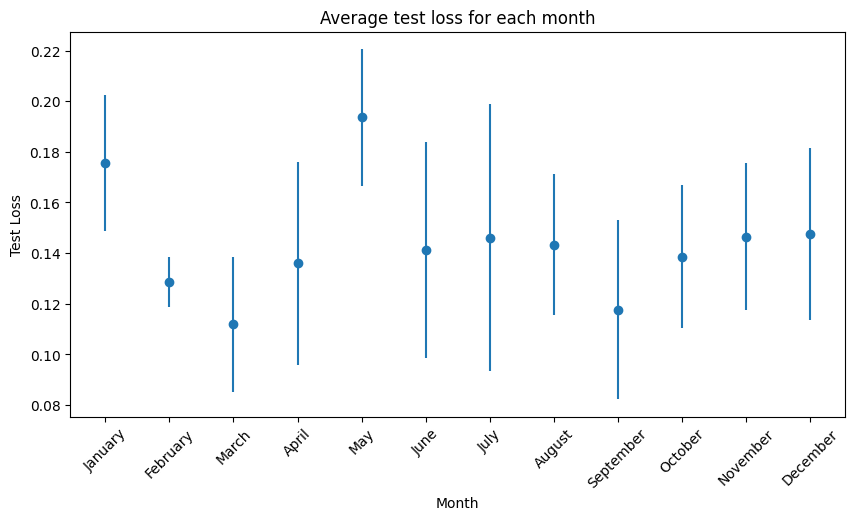

In [134]:
# pass test loss to an array
test_losses = np.full((5, 12), np.nan)
for ind, year in enumerate([2014, 2015, 2016, 2017, 2018]):
    # create a 5x12 array with the test loss for each month
    test_loss = np.array(df8[(df8.lr==best_params[0]) & (df8.weight_decay==best_params[1]) & (df8.test_year==year)]['test_loss'].values[0])
    test_losses[ind, :test_loss.shape[0]] = test_loss.flatten()
    
plt.figure(figsize=(10, 5))
plt.errorbar(np.arange(1, 13), test_losses.mean(axis=0), yerr=test_losses.std(axis=0), fmt='o')
plt.title('Average test loss for each month')
plt.xticks(np.arange(1, 13), [months_name[i] for i in np.arange(1, 13)], rotation=45)
plt.xlabel('Month')
plt.ylabel('Test Loss')
plt.show()

### Show results for each scenario

In [76]:
# create a df with the columns as scnearios and rows as mean_test_loss for each year
scenarios = ['Scenario 4', 'Scenario 5', 'Scenario 6', 'Scenario 7', 'Scenario 8']
df_results = pd.DataFrame(columns=scenarios)

for year in [2014, 2015, 2016, 2017, 2018]:
    df_results = df_results.append({
        'Scenario 4': df4[(df4['lr']==df4.groupby(['lr'])['test_loss'].mean().idxmin()) & (df4['test_year']==year)]['test_loss'].values[0],
        'Scenario 5': df5[(df5['lr']==df5.groupby(['lr'])['mean_test_loss'].mean().idxmin()) & (df5['test_year']==year)]['mean_test_loss'].values[0],'Scenario 6': df6[(df6['lr']==df6.groupby(['lr'])['mean_test_loss'].mean().idxmin()) & (df6['test_year']==year)]['mean_test_loss'].values[0],
        'Scenario 7': df7[(df7['lr']==df7.groupby(['lr'])['mean_test_loss'].mean().idxmin()) & (df7['test_year']==year)]['mean_test_loss'].values[0],
        'Scenario 8': df8[(df8['lr']==df8.groupby(['lr'])['mean_test_loss'].mean().idxmin()) & (df8['test_year']==year)]['mean_test_loss'].values[0]}, ignore_index=True)
    
df_results.index = [2014, 2015, 2016, 2017, 2018]
display(df_results)

for scenario in scenarios:
    print(f'{scenario}: {df_results[scenario].mean():.3f} ± {df_results[scenario].std():.3f}')

,Scenario 4,Scenario 5,Scenario 6,Scenario 7,Scenario 8
2014,1.5211434,0.201382,0.252411,0.201055,0.142858
2015,1.7554168,0.200371,0.278704,0.201463,0.133250
2016,0.9308866,0.225365,0.270227,0.251875,0.152743
2017,2.0512104,0.192021,0.268967,0.193672,0.149622
2018,1.2641034,0.202874,0.274991,0.218301,0.140679


Scenario 4: 1.505 ± 0.433
Scenario 5: 0.204 ± 0.012
Scenario 6: 0.269 ± 0.010
Scenario 7: 0.213 ± 0.023
Scenario 8: 0.144 ± 0.008
